# Chapter 6: Multiclass Classification

### 6.1. Ways of Training a Multiclass Classifier

When addressing multiclass classification problems, there are several approaches to consider. Each approach has its strengths, weaknesses, and contexts in which it excels. This section provides an overview of three primary methods for building multiclass classifiers: direct training, one-vs-all and ensembling, and one-vs-one ensembling.

#### 6.1.1. Comparative Advantages and Disadvantages

**Direct Training**

In this approach, the classifier is trained to handle multiple classes simultaneously, leveraging algorithms like XGBoost, AdaBoost, or LightGBM with multiclass objectives. The advantages of this method are as follows. First, it is simple to implement and does not require transforming the dataset into binary problems. Second, it is optimized for the multiclass objective, potentially leading to better overall performance. Third, it is computationally efficient in terms of model training since only one model is required. However, this approach may struggle when class distributions are imbalanced or when specific classes require specialized handling. Additionally, it offers limited interpretability compared to one-vs-all models.

**One-vs-All and Ensembling**

This approach involves training separate binary classifiers, each tasked with distinguishing one class from all others. The predictions are then combined into a multiclass classifier, often using ensembling methods like soft voting, hard voting, or stacking. One of its advantages is that it allows the flexibility to fine-tune models for each individual class, which can improve performance for specific classes. Furthermore, it can handle imbalanced datasets better since each model focuses on a single class. Another advantage is modularity, which makes it easier to interpret performance per class. On the downside, it requires training multiple models, which increases computational cost and complexity. Moreover, combining predictions can sometimes introduce additional errors, especially if models for some classes are weak.

**One-vs-One Ensembling**

In this approach, binary classifiers are trained for every pair of classes. For $n$ classes, this results in $\frac{n(n-1)}{2}$ classifiers. The predictions from these classifiers are combined to make final multiclass predictions. One advantage of this method is its effectiveness when the decision boundaries between specific pairs of classes are complex. Additionally, it provides high resolution in learning decision boundaries between two specific classes at a time. However, training becomes computationally expensive for large numbers of classes due to the exponential growth in the number of classifiers. Furthermore, the combination of pairwise predictions into a final multiclass prediction can be complex and may lack interpretability.

Each method provides a unique trade-off between complexity, computational cost, and performance. The choice of approach often depends on the dataset characteristics, computational resources, the specific requirements of the problem at hand, and cost-benefit considerations from the business point of view.

## 6.2. Training Direction Multiclass Classifiers

We will train three multiclass classifiers using the XGBoost, AdaBoost, and LightGBM methods. The first two have been extensively discussed already throughout this notebook. The latter, LightGBM, will be introduced and utilized here for the first time. Our motivation for using LightGBM stems from its speed in training, efficiency due to a histogram-based algorithm, versatility with support for various loss functions and hyperparameter options, and its ability to handle large datasets while leveraging GPU acceleration. Further elaboration on LightGBM's strengths and its performance will follow as we proceed.

***Note:*** We will be using the selected feature set obtained from the SHAP analysis conducted in Chapter 5. Recall that in that chapter, we benchmarked several feature selection methods (SHAP-based, RFE-based, and static feature importance), and the SHAP-based selection emerged as the best after retraining and evaluation.

#### 6.2.1. Feature Selection Pipeline

In [193]:
def create_disjoint_subsets(X, y, sizes, random_state=42):
    """
    create disjoint subsets of data with proportional representation for each digit.

    parameters:
        - X: ndarray, feature matrix.
        - y: ndarray, labels corresponding to the features.
        - sizes: dict, dictionary specifying sizes for subsets.
        - random_state: int, seed for reproducibility.

    returns:
        - subsets: dict, dictionary containing disjoint subsets (keys: X_0, X_1, ...).
    """
    np.random.seed(random_state)
    subsets = {}
    remaining_indices = np.arange(len(y))

    for subset_name, subset_size in sizes.items():
        mask = create_balanced_subset_mask(y[remaining_indices], n_per_digit=subset_size // len(np.unique(y)), random_state=random_state)
        subset_indices = remaining_indices[mask]
        subsets[subset_name] = {
            "X": X[subset_indices],
            "y": y[subset_indices]
        }
        print(f"subset[{subset_name}] has {len(subset_indices)} images")
        remaining_indices = np.setdiff1d(remaining_indices, subset_indices)
    return subsets

In [674]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class SHAPFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, top_features):
        self.top_features = top_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[:, self.top_features]

# create a pipeline for feature selection and data splitting
feature_selection_pipeline = Pipeline([
    ("shap_selector", SHAPFeatureSelector(top_features=feature_sets["SHAP"]))
])

In [ ]:
sizes = {
    "X_0": 200000,  # training data for base models
    "X_1": 18000,   # data for stack (layer 1)
    "X_2": 18000,   # data for potential stack (layer 2), or stack layer 1 (if no layer 2 stacking used)
    "X_3": 4000     # hold-out validation data
}

In [ ]:
# apply the pipeline to filter the dataset
filtered_X_train = feature_selection_pipeline.fit_transform(train_digits_flattened, train_digits_labels)
filtered_y_train = train_digits_labels
subsets = create_disjoint_subsets(filtered_X_train, filtered_y_train, sizes)

# extract subsets for training and evaluation
X_0 = subsets['X_0']['X']
y_0 = subsets['X_0']['y']
X_3 = subsets['X_3']['X']
y_3 = subsets['X_3']['y']

#### 6.2.2. Modular Evaluation Functionality

We will use the following functionality to modularly compute the performance of trained multiclass classifers with respost to precision, recall, f1-score, ROC, and accuracy. Also, we provide funcitonality for converting the results into dataframes which we use later for comparative assessment of performances using visualizations. 

In [698]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import pandas as pd
import numpy as np

def evaluate_multiclass_model(y_test, y_pred, y_pred_probs):
    """
    Evaluate a multiclass model and compile classification metrics.

    Parameters:
        y_test (ndarray): True labels.
        y_pred (ndarray): Predicted labels.
        y_pred_probs (ndarray): Predicted probabilities.

    Returns:
        dict: A dictionary containing:
            - Classification Report: DataFrame of precision, recall, F1-score.
            - Per-Class Accuracy: Dictionary of accuracy per class.
            - Per-Class ROC AUC: Dictionary of ROC AUC per class.
    """
    # Classification Report
    classification_rep = classification_report(y_test, y_pred, digits=3, output_dict=True)
    classification_rep_df = pd.DataFrame(classification_rep).T

    # Per-Class Accuracy
    unique_classes = np.unique(y_test)
    per_class_accuracy = {
        digit: accuracy_score(y_test[y_test == digit], y_pred[y_test == digit]) for digit in unique_classes
    }

    # Per-Class ROC AUC
    roc_auc_scores = roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average=None)
    roc_auc_per_class = {digit: roc_auc for digit, roc_auc in zip(unique_classes, roc_auc_scores)}

    # Compile results
    results = {
        "Classification Report": classification_rep_df,
        "Per-Class Accuracy": per_class_accuracy,
        "Per-Class ROC AUC": roc_auc_per_class,
    }

    return results

#### 6.2.3. Naming Convention for Models

Developing multiple multiclass classifiers, and studying the comparative performances requires a systematic treatment. Otherwise, before we can get far, we will find it very hard to retrieve data properly and use themm effectively. As a result, we have adopted a naming convention for storing the computaiton resutls. The function `results_to_dataframe` below accepts the computation performed during model training and evaluations as input and converts them into a dataframe with specific format. Here we explain the format.

The naming convention for models follows a systematic and structured format to encapsulate key information about the model's type, target digit, and position in the training hierarchy. Below is the abstract syntax and detailed explanations for each component.

#### Abstract Syntax
The **Model** name follows this pattern:  

> `digit-modelName-layer`  

- `digit`: An integer ranging from 0 to 9, representing the digit the model is trained to classify in a one-vs-all scenario or as part of a multiclass classifier.
- `modelName`: Encodes the algorithm and specific training configuration, defined as:

where:
- **`baseMethod`**: The core algorithm used for training, chosen from `{xgb, ada, lgbm}` representing XGBoost, AdaBoost, and LightGBM, respectively.
- `literal_1` (optional): Indicates additional ensembling methods:
  - `St`: Stacking method.
  - `Sv`: Soft voting method.
  - `''`: Empty string, indicating no ensembling method is applied.
- `literal_2` (optional): Specifies whether the model is a multiclass classifier:
  - `M`: Indicates the results pertain to the multiclass version of the model.
  - `''`: Empty string, indicating the model is part of a one-vs-all training setup.

- `layer`: Denotes the training layer in the hierarchy:
- `L0`: Base layer (e.g., individual one-vs-all models).
- `L1, L2, ...`: Higher layers indicating ensemble techniques applied on the base models.

#### Examples with Explanations
1. **`0-ada-L0`:** 
 - `digit=0`: Model targets digit 0 in a one-vs-all setup.  
 - `modelName=ada`: Model is trained using the AdaBoost algorithm.  
 - `layer=L0`: Model is part of the base layer.

2. **`3-xgbSt-L1`**:  
 - `digit=3`: Model targets digit 3.  
 - `modelName=xgbSt`: Stacking method applied to XGBoost one-vs-all models.  
 - `layer=L1`: Indicates the first ensemble layer.

3. **`lgbmM-L0`**:  
 - `digit`: Not specified (multiclass model).  
 - `modelName=lgbmM`: LightGBM is used for training, and the results are for the multiclass version.  
 - `layer=L0`: Indicates the base layer.

4. **`7-adaSvM-L2`**:  
 - `digit=7`: Model targets digit 7, indicating the performance of the model for that digit.  
 - `modelName=adaSvM`: AdaBoost models combined via soft voting into a multiclass classifier.  
 - `layer=L2`: Represents the second ensemble layer.

#### Why Adopting A Naming Convention

Adopting a structured and consistent naming convention is more than an organizational choice—it plays a vital role in enhancing the clarity, scalability, and effectiveness of our work. Here are the key reasons:

1. **Programmatic Summarization and Filtering**  
   The structured naming scheme embeds essential metadata directly into model identifiers. This allows us to effortlessly filter, group, and summarize results programmatically. For instance, we can easily isolate the performance of all models trained for a specific digit, compare results across layers, or benchmark different algorithms, without needing manual intervention.

2. **Streamlined Visualization**  
   A well-defined naming convention simplifies the creation of visualizations. By systematically categorizing results, we can plot trends, analyze outliers, and generate insightful comparisons across models, layers, or algorithms, ensuring that the visual narratives are accurate and informative.

3. **Scalability and Automation**  
   As experiments grow in complexity, the naming convention becomes a backbone for scaling and automating workflows. Adding new models, integrating alternative algorithms, or introducing additional metrics can be seamlessly managed. The structure eliminates ambiguity, ensuring new components integrate without conflicts or inconsistencies.

4. **Reproducibility and Traceability**  
   In a research-oriented workflow, reproducibility is paramount. The naming convention ensures that each result is explicitly tied to its configuration, digit, and layer. This transparency makes it easy to trace results back to their source and replicate experiments accurately.

5. **Facilitating Collaboration and Documentation**  
   A clear naming convention enhances collaboration by ensuring that all stakeholders—whether data scientists, engineers, or reviewers—can intuitively understand the structure of the results. It acts as a form of self-documentation, reducing the need for additional explanations and enabling others to build upon the work seamlessly.

In [705]:
import pandas as pd

def truncate_to_three_decimals(value):
    """
    Truncate a floating-point value to three decimal places without rounding.
    """
    value_str = f"{value:.10f}"  # Convert to string with high precision
    truncated_str = value_str[:value_str.find('.') + 4]  # Keep three decimals
    return float(truncated_str)

def results_to_dataframe(results, model_name, layer):
    """
    Convert results from model evaluation into a structured DataFrame.

    Parameters:
        results (dict): A dictionary containing evaluation metrics:
            - Classification Report: DataFrame with precision, recall, F1-score.
            - Per-Class Accuracy: Dictionary of digit-wise accuracy.
            - Per-Class ROC AUC: Dictionary of digit-wise ROC AUC.
        model_name (str): Model name identifier (e.g., "xgbM", "lgbmM", "adaM").
        layer (int): The layer number.

    Returns:
        pd.DataFrame: A DataFrame with the desired structure.
    """
    # Extract components from results
    classification_report_df = results["Classification Report"]
    per_class_accuracy = results["Per-Class Accuracy"]
    per_class_roc_auc = results["Per-Class ROC AUC"]

    # Initialize a list to store rows for the DataFrame
    data = []

    # Iterate over each digit in the results
    for digit in range(10):
        # Extract metrics for the current digit and truncate
        precision = truncate_to_three_decimals(classification_report_df.loc[str(digit), "precision"])
        recall = truncate_to_three_decimals(classification_report_df.loc[str(digit), "recall"])
        f1_score = truncate_to_three_decimals(classification_report_df.loc[str(digit), "f1-score"])
        accuracy = truncate_to_three_decimals(per_class_accuracy[digit])
        roc_auc = truncate_to_three_decimals(per_class_roc_auc[digit])

        # Construct the Model and Layer fields
        model = f"{digit}-{model_name}-L{layer}"

        # Append the row
        data.append({
            "Model": model,
            "F1_score": f1_score,
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "roc_auc": roc_auc,
            "Digit": digit,
            "TrainingMethod": model_name,
            "Layer": f"L{layer}"
        })

    # Convert the list of rows into a DataFrame
    return pd.DataFrame(data)

### 6.2.4. An XGBoost Multiclass Classifier

Up until now, we have used XGBoost to build efficient 8-vs-all classifiers. However, XGBoost also provides the capability to build multiclass classifiers directly, leveraging its robust boosting algorithms for tasks involving multiple classes.

In [701]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from xgboost import XGBClassifier

def train_xgboost_multiclass(X_train, y_train, X_test, y_test):
    """
    Train and evaluate an XGBoost multiclass classifier.

    Parameters:
        X_train (ndarray): Training features.
        y_train (ndarray): Training labels.
        X_test (ndarray): Test features (hold-out set).
        y_test (ndarray): Test labels (hold-out set).

    Returns:
        xgb_multiclass (XGBClassifier): Trained XGBoost model.
        results (dict): Evaluation metrics including classification report, accuracy, and ROC AUC.
    """
    print("Training XGBoost Multiclass Classifier...")
    xgb_multiclass = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", random_state=42)
    xgb_multiclass.fit(X_train, y_train)

    print("Evaluating XGBoost Multiclass Classification on Hold-out Data")
    # Predict probabilities and class labels
    y_pred_probs = xgb_multiclass.predict_proba(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_pred_probs = xgb_multiclass.predict_proba(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Use the utility function for evaluation
    results = evaluate_multiclass_model(y_test, y_pred, y_pred_probs)

    return xgb_multiclass, results

In [702]:
# train the model on X_0, evaluate it on the validation data (X_3)
xgb_multiclass, xgbM_results = train_xgboost_multiclass(X_0, y_0, X_3, y_3)

Training XGBoost Multiclass Classifier...
Evaluating XGBoost Multiclass Classification on Hold-out Data


In [711]:
xgbM_results_df = results_to_dataframe(xgbM_results, 'xgbM', 0)

xgbM_results_df

,Model,F1_score,precision,recall,accuracy,roc_auc,Digit,TrainingMethod,Layer
0,0-xgbM-L0,0.990,0.987,0.992,0.992,0.999,0,xgbM,L0
1,1-xgbM-L0,0.986,0.994,0.977,0.977,0.999,1,xgbM,L0
2,2-xgbM-L0,0.985,0.977,0.992,0.992,0.999,2,xgbM,L0
3,3-xgbM-L0,0.981,0.989,0.972,0.972,0.999,3,xgbM,L0
4,4-xgbM-L0,0.980,0.970,0.990,0.990,0.999,4,xgbM,L0
5,5-xgbM-L0,0.983,0.980,0.987,0.987,0.999,5,xgbM,L0
6,6-xgbM-L0,0.985,0.982,0.987,0.987,0.999,6,xgbM,L0
7,7-xgbM-L0,0.987,0.987,0.987,0.987,0.999,7,xgbM,L0
8,8-xgbM-L0,0.982,0.989,0.975,0.975,0.999,8,xgbM,L0
9,9-xgbM-L0,0.976,0.977,0.975,0.975,0.999,9,xgbM,L0


That is it! Training a multiclass classifier using the off-the-shelf XGBoost is simple and efficient. We will discuss the performances in depth under Section 6.2.4. A brief remark here is worthwhile: as we see above, XGBoost is performing an excellent job for every digit. We will soon compare it against its two other rivals, namely AdaBoost and LightGBM, to gain a benchmarking perspective.

### 6.2.5. AdaBoost Multiclass Classifier

Next, we will explore training a multiclass classifier using the AdaBoost method, leveraging its iterative learning strategy to address classification challenges.

In [708]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

def train_adaboost_multiclass(X_train, y_train, X_test, y_test):
    """
    Train and evaluate an AdaBoost multiclass classifier.

    Parameters:
        X_train (ndarray): Training features.
        y_train (ndarray): Training labels.
        X_test (ndarray): Test features.
        y_test (ndarray): Test labels.

    Returns:
        tuple: The trained AdaBoost model and a dictionary of evaluation results.
    """
    print("Training AdaBoost Multiclass Classifier (based on the hyperparameters found in Chapter 3)...")
    
    # Hyperparameters for AdaBoost
    ada_base_estimator_params = {
        "max_depth": 6,
        "max_features": 0.6,
        "ccp_alpha": 0.0,
        "criterion": "gini",
        "min_samples_leaf": 1,
        "min_samples_split": 2,
    }
    ada_params = {
        "algorithm": "SAMME",
        "learning_rate": 1.0,
        "n_estimators": 100,
        "random_state": 42,
    }

    # Define and train the model
    base_estimator = DecisionTreeClassifier(**ada_base_estimator_params)
    ada_multiclass = AdaBoostClassifier(estimator=base_estimator, **ada_params)
    ada_multiclass.fit(X_train, y_train)

    print("Evaluating AdaBoost Multiclass on Hold-out Data...")
    # Predict probabilities and class labels
    y_pred_probs = ada_multiclass.predict_proba(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Use the utility function for evaluation
    results = evaluate_multiclass_model(y_test, y_pred, y_pred_probs)

    return ada_multiclass, results

In [709]:
ada_multiclass, adaM_results = train_adaboost_multiclass(X_0, y_0, X_3, y_3)

Training AdaBoost Multiclass Classifier (based on the hyperparameters found in Chapter 3)...
Evaluating AdaBoost Multiclass on Hold-out Data...


In [713]:
adaM_results_df = results_to_dataframe(adaM_results, 'adaM', 0)

adaM_results_df

,Model,F1_score,precision,recall,accuracy,roc_auc,Digit,TrainingMethod,Layer
0,0-adaM-L0,0.978,0.977,0.980,0.980,0.999,0,adaM,L0
1,1-adaM-L0,0.982,0.984,0.980,0.980,0.999,1,adaM,L0
2,2-adaM-L0,0.965,0.965,0.965,0.965,0.997,2,adaM,L0
3,3-adaM-L0,0.945,0.936,0.955,0.955,0.995,3,adaM,L0
4,4-adaM-L0,0.964,0.955,0.972,0.972,0.998,4,adaM,L0
5,5-adaM-L0,0.952,0.959,0.945,0.945,0.995,5,adaM,L0
6,6-adaM-L0,0.975,0.975,0.975,0.975,0.998,6,adaM,L0
7,7-adaM-L0,0.960,0.971,0.950,0.950,0.996,7,adaM,L0
8,8-adaM-L0,0.954,0.959,0.950,0.950,0.994,8,adaM,L0
9,9-adaM-L0,0.931,0.925,0.937,0.937,0.993,9,adaM,L0


Great! Now we move to training a multiclass classifer using the LightGBM method.

## 6.2.6. Training a Multiclass Classifier Using LightGBM

LightGBM, short for Light Gradient Boosting Machine, is a highly efficient and scalable implementation of gradient boosting designed for speed, efficiency, and performance. It has gained widespread popularity for its ability to handle large datasets and achieve competitive results in a fraction of the training time compared to other gradient boosting frameworks. LightGBM achieves this efficiency through a unique training mechanism that includes histogram-based learning, leaf-wise tree growth, and feature bundling.

#### Training Mechanism

LightGBM builds decision trees sequentially, like other gradient boosting frameworks such as XGBoost. However, its training process incorporates several innovative strategies that set it apart:

1. **Histogram-Based Learning**: LightGBM discretizes continuous feature values into discrete bins, effectively creating histograms for each feature. By using these histograms, the algorithm can quickly find the optimal split point for decision tree nodes. This reduces computational complexity and memory usage, especially when handling large datasets with many features. The binning process also enables LightGBM to process data faster than algorithms that evaluate each possible split point, such as XGBoost.

2. **Leaf-Wise Growth**:  LightGBM grows decision trees leaf-wise instead of level-wise. At each iteration, it selects the leaf with the highest loss reduction to split. This targeted approach allows LightGBM to prioritize areas of the feature space where the model can improve the most. While this strategy often leads to better accuracy and faster convergence, it can increase the risk of overfitting on smaller datasets or datasets with high noise.

3. **Feature Bundling**:  LightGBM bundles sparse features into a single pseudo-feature by analyzing correlations between them. This technique reduces dimensionality and improves computational efficiency without sacrificing predictive performance. Feature bundling is particularly beneficial for datasets with high sparsity, such as those encountered in text or categorical data.

4. **Categorical Feature Handling**:  Unlike XGBoost and AdaBoost, LightGBM natively supports categorical features. It uses a specific algorithm to find the optimal split for categorical variables without requiring one-hot encoding. This reduces preprocessing time and further optimizes memory usage.

5. **Regularization and Overfitting Control**:  LightGBM incorporates several hyperparameters to control overfitting, such as `max_depth`, `min_data_in_leaf`, and `lambda_l1/l2` regularization terms. Combined with early stopping criteria, these mechanisms help ensure the model generalizes well to unseen data.

6. **Distributed Learning**:  LightGBM is designed to scale easily across multiple machines, making it suitable for distributed training on very large datasets. It achieves this by optimizing network communication and efficiently partitioning data.

#### Strengths of LightGBM
1. **High Efficiency**: The histogram-based algorithm enables faster training and lower memory consumption.
2. **Support for Categorical Features**: LightGBM can directly handle categorical features without requiring one-hot encoding.
3. **Scalability**: Its ability to handle large datasets and leverage GPU acceleration makes it suitable for computationally intensive tasks.
4. **Versatility**: LightGBM supports various loss functions and hyperparameters, making it adaptable to a wide range of applications.
5. **Better Performance on Sparse Data**: Feature bundling and histogram-based learning enhance its performance on datasets with sparse or high-dimensional features.

#### Comparison with XGBoost and AdaBoost
1. **Efficiency**: LightGBM's histogram-based learning and leaf-wise growth make it faster and more memory-efficient than XGBoost.
2. **Tree Growth**: Unlike XGBoost, which grows trees level-wise, LightGBM grows them leaf-wise, potentially yielding higher accuracy but at a risk of overfitting.
3. **Categorical Features**: While XGBoost and AdaBoost require preprocessing like one-hot encoding for categorical features, LightGBM can natively handle them.
4. **Robustness**: XGBoost is generally more robust to hyperparameter changes, whereas LightGBM requires more careful tuning.
5. **Training Complexity**:
   - XGBoost: $O(n \cdot k)$, where $n$ is the number of samples and $k$ is the number of features.
   - LightGBM: $O(n \cdot \log(k))$, offering a more efficient scaling for high-dimensional data.
   - AdaBoost: $O(n \cdot k \cdot t)$, where $t$ is the number of iterations, potentially making it slower for large datasets.

Next, we proceed with training a LightGBM multiclass classifier and compare its performance to XGBoost and AdaBoost.

In [679]:
def train_lightgbm_multiclass(X_train, y_train, X_test, y_test):
    print("Training LightGBM Multiclass Classifier...")
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    lgbm_params = {
        "objective": "multiclass",
        "num_class": 10,
        "random_state": 42,
    }
    lgbm_model = lgb.train(params=lgbm_params, train_set=train_data, valid_sets=[test_data], num_boost_round=100)
    
    print("Evaluating LightGBM Multiclass on Hold-out Data")
    # Predict probabilities and class labels
    y_pred_probs = lgbm_model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Use the utility function for evaluation
    results = evaluate_multiclass_model(y_test, y_pred, y_pred_probs)

    return lgbm_model, results

In [681]:
lgbm_model, lgbmM_results = train_lightgbm_multiclass(X_0, y_0, X_3, y_3)

Training LightGBM Multiclass Classifier...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107698
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 580
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
Evaluating LightGBM Multiclass on Hold-out Data


In [714]:
lgbmM_results_df = results_to_dataframe(lgbmM_results, 'lgbmM', 0)

lgbmM_results_df

,Model,F1_score,precision,recall,accuracy,roc_auc,Digit,TrainingMethod,Layer
0,0-lgbmM-L0,0.991,0.990,0.992,0.992,0.999,0,lgbmM,L0
1,1-lgbmM-L0,0.986,0.994,0.977,0.977,0.999,1,lgbmM,L0
2,2-lgbmM-L0,0.982,0.973,0.992,0.992,0.999,2,lgbmM,L0
3,3-lgbmM-L0,0.974,0.982,0.967,0.967,0.999,3,lgbmM,L0
4,4-lgbmM-L0,0.980,0.972,0.987,0.987,0.999,4,lgbmM,L0
5,5-lgbmM-L0,0.982,0.982,0.982,0.982,0.999,5,lgbmM,L0
6,6-lgbmM-L0,0.985,0.985,0.985,0.985,0.999,6,lgbmM,L0
7,7-lgbmM-L0,0.986,0.985,0.987,0.987,0.999,7,lgbmM,L0
8,8-lgbmM-L0,0.973,0.974,0.972,0.972,0.999,8,lgbmM,L0
9,9-lgbmM-L0,0.974,0.977,0.972,0.972,0.999,9,lgbmM,L0


### 6.2.7. Benchmarking Layer Zero Multiclass Classifiers

Under this section, we visualize and analyze the performance of the three models in terms of precision and recall. Given the modular nature of the visualization code, you can input the name of any metric of interest (e.g., F1-score, accuracy, ROC) into the function to generate corresponding visualizations.

In [716]:
layer_0_multiclassifiers_results_df = pd.concat([lgbmM_results_df,xgbM_results_df,adaM_results_df])

In [722]:
def plot_single_metric_heatmap(metrics_df, metric, colorMap="YlGnBu"):
    """
    Plot a heatmap for a single metric, showing models on the x-axis
    and digits on the y-axis. Annotates the values vertically.

    Parameters:
    - metrics_df: pd.DataFrame, combined metrics for all models.
    - metric: str, the metric to visualize (e.g., "precision", "recall").
    """
    # Pivot the data for the heatmap
    heatmap_data = metrics_df.pivot(index="Digit", columns="Model", values=metric)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".3f",
        cmap=colorMap,
        cbar_kws={"label": metric.capitalize()},
        annot_kws={"size": 8, "rotation": 90},  # Rotate annotations vertically
    )
    plt.title(f"Heatmap of {metric.capitalize()} by Model and Digit")
    plt.xlabel("Model")
    plt.ylabel("Digit")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

### 6.2.7.1. Precision Analysis Across Models and Digits

#### Digits Consistently Performing Well
Digits **0, 1, and 7** consistently achieve high precision scores across all three models (XGBoost, LightGBM, and AdaBoost). Their precision values are generally above **0.98**, indicating that the models rarely misclassify other digits as these. The strong performance might be due to their **distinctive patterns and features**, which make them easier to differentiate from other digits.

#### Digits That Are Comparatively Difficult
Digit **9** shows comparatively lower precision across the three models, often scoring around **0.95** or slightly less. This may result from its **visual resemblance to digits like 8 or 4**, leading to more false positives. Similarly, digit **8** occasionally exhibits a slight drop in precision but generally performs reasonably well.

#### XGBoost vs. LightGBM
XGBoost and LightGBM both deliver strong precision across most digits, with scores frequently in the **0.97–0.99 range**. However:
- LightGBM often matches or slightly exceeds XGBoost in precision for digits such as **2 and 5**.
- For most digits, the differences are negligible, making both models highly competitive in precision.

This tiny difference nonetheless can be overcome by some tuning efforts (the extent of which canonly be explored experimentally).

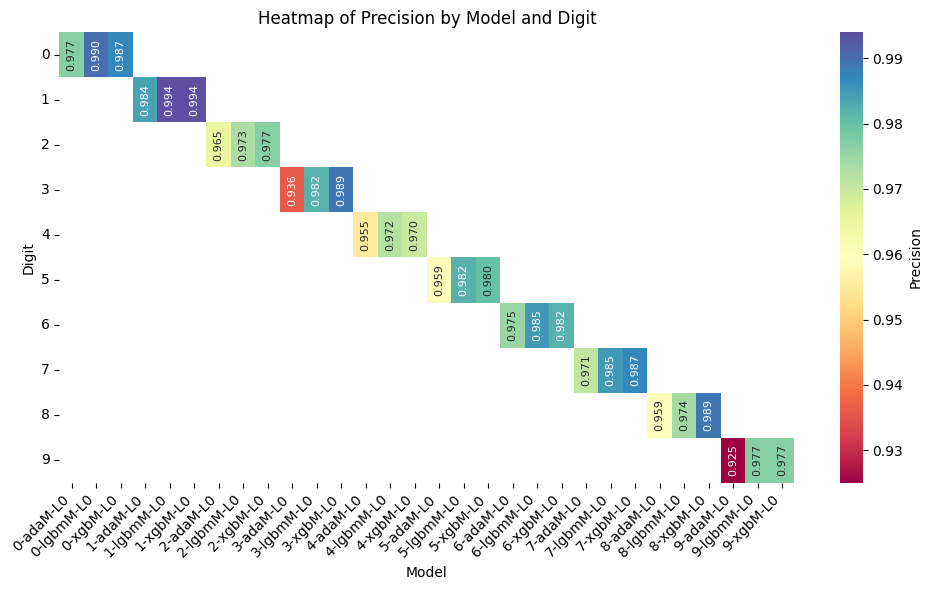

In [731]:
plot_single_metric_heatmap(layer_0_multiclassifiers_results_df, 'precision', colorMap='Spectral')

### 6.2.7.2. Recall Analysis Across Models and Digits

#### Digits Consistently Performing Well
Digits **0, 1, and 7** also perform strongly in recall across all three models, with scores consistently around **0.98 or higher**. This indicates that the models correctly classify most instances of these digits without missing them.

#### Digits That Are Comparatively Difficult
Digit **9** emerges as the most challenging for recall, with scores ranging from **0.93 to 0.95**, depending on the model. This suggests that models often misclassify digit 9 as other digits, likely due to its **shared features with visually similar digits like 8 or 4**. Digit **8** also occasionally shows lower recall compared to easier digits but maintains competitive performance overall.

#### XGBoost vs. LightGBM
- **XGBoost shows an advantage in recall**, particularly for digits like **3, 6, and 9**, where it outperforms LightGBM by small but notable margins.
- This indicates XGBoost’s stronger ability to minimize false negatives, making it slightly better at capturing all instances of harder digits.

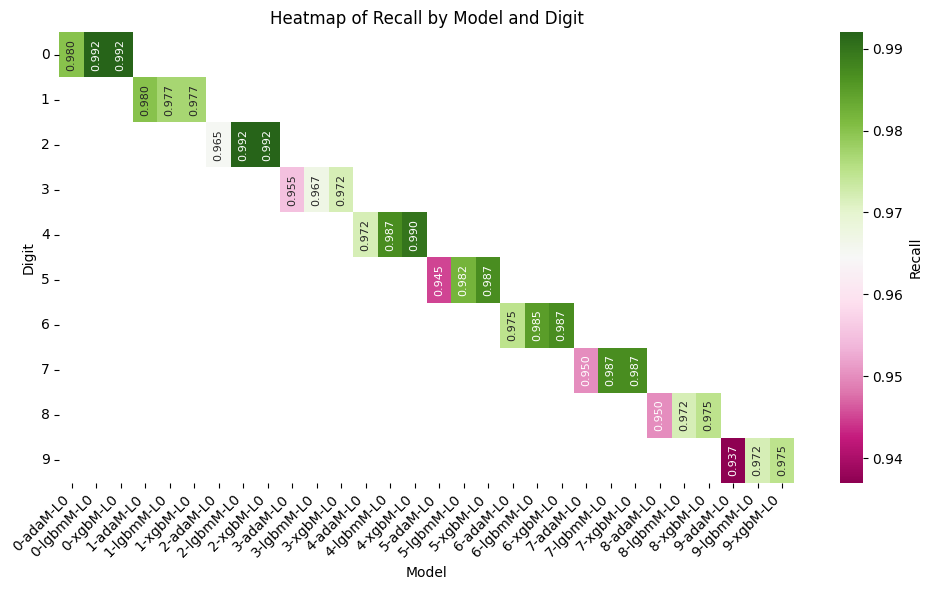

In [726]:
plot_single_metric_heatmap(layer_0_multiclassifiers_results_df, "recall", colorMap='PiYG')

### 6.2.7.3. AdaBoost’s Underperformance in Multiclass Classification

The multiclass implementation of AdaBoost demonstrates notable underperformance compared to XGBoost and LightGBM in both precision and recall. This is observed consistently across almost all digits. It appears that AdaBoost, in its direct multiclass setup, struggles to effectively separate class boundaries. This limitation might be due to its training mechanism, which focuses on iteratively reweighting and correcting misclassified samples. While this approach is powerful in simpler settings, it seems less effective in a multiclass environment where balancing class boundaries and generalizing across multiple categories is crucial.

For example, as seen in Chapter 3, the 8-vs-all AdaBoost classifier achieved a precision of **0.985** and a recall of **0.961** when trained with the same hyperparameters used in the multiclass setting. However, the multiclass AdaBoost classifier, when limited to evaluating digit 8, drops to a precision of **0.959** and a recall of **0.950**. Despite identical hyperparameters, this significant performance gap highlights the challenges AdaBoost faces when directly trained as a multiclass model.

### Potential Ways Forward

While AdaBoost's direct multiclass implementation shows limitations, there are promising avenues to address its shortcomings:

1. **Hyperparameter Tuning**  
   A detailed exploration of the hyperparameter space specific to multiclass classification may improve AdaBoost's performance. Adjusting parameters like learning rate, the number of estimators, or the depth of the base decision trees could lead to better class boundary separation and improved generalization.

2. **One-vs-All Approach with Ensembling**  
   Another promising path is to train one-vs-all AdaBoost models for each digit and then combine their outputs through ensembling techniques like soft voting or stacking. This approach allows us to leverage AdaBoost’s strength in binary classification for each digit while addressing the limitations it faces in multiclass classification directly.

### Looking Ahead
In the next section, we will explore the one-vs-all AdaBoost approach, train individual models for each digit, and evaluate their combined performance through ensembling. This will allow us to assess whether this alternative strategy can close the performance gap with XGBoost and LightGBM, or even surpass them.


## 6.3. Training And Ensembling One-vs-All AdaBoost Models

We shall first train ten one-vs-all AdaBoost models, one for each digit 0-9. Once trained, we will use two ensembling techniques, namely soft voting and stacking to aggregate their results into building a multiclass classifer. Once trained, we evaluate their performance and benchmark them against the previous three techniques.

### 6.3.1. Systematic Training of One-vs-All Models

Once again, we use a systematic approach for model building and evaluation. You will note that the code provided also includes the training of one-vs-all models based on both XGBoost and AdaBoost. This setup has been provisioned for the curious reader to explore further how a multiclass classifier built using XGBoost directly would compare against an ensemble of one-vs-all XGBoost-based models. 

However, the author shall not delve into that direction at this point, leaving it as an opportunity for readers to independently explore this avenue and uncover additional insights.

In [ ]:
class Layer0Training(BaseEstimator):
    def __init__(self, xgb_params, ada_base_estimator_params, ada_params):
        """
        initialize Layer 0 training.

        parameters:
            - xgb_params: dict, hyperparameters for XGBoost.
            - ada_base_estimator_params: dict, hyperparameters for AdaBoost's base estimator (DecisionTreeClassifier).
            - ada_params: dict, hyperparameters for AdaBoost.
        """

        self.xgb_params = xgb_params
        self.ada_base_estimator_params = ada_base_estimator_params
        self.ada_params = ada_params
        self.layer_0_XGB = {}
        self.layer_0_Ada = {}

    def fit(self, X, y):
        """
        train one-vs-all classifiers for XGBoost and AdaBoost.

        parameters:
            - X: ndarray, training data.
            - y: ndarray, training labels.
        """
        unique_digits = np.unique(y)
        for digit in unique_digits:
            print(f"Training one-vs-all for digit {digit}...")

            # binary labels: 1 for the digit, 0 for others
            y_binary = (y == digit).astype(int)

            # train XGBoost
            xgb_params_updated = self.xgb_params.copy()
            xgb_params_updated["n_estimators"] = int(xgb_params_updated["n_estimators"] * 1.3)  # Increase n_estimators by 30%
            xgb_model = XGBClassifier(**xgb_params_updated)  # Correct usage
            xgb_model.fit(X, y_binary)
            self.layer_0_XGB[f"{digit}_vs_all"] = xgb_model

            # train AdaBoost
            ada_base_estimator = DecisionTreeClassifier(**self.ada_base_estimator_params)
            ada_model = AdaBoostClassifier(estimator=ada_base_estimator, **self.ada_params)
            ada_model.fit(X, y_binary)
            self.layer_0_Ada[f"{digit}_vs_all"] = ada_model

        print("Layer 0 training complete.")
        return self

In [225]:
# combine Feature Selection and Layer 0 Training in a Pipeline
feature_selection_pipeline = Pipeline([
    ("shap_selector", SHAPFeatureSelector(top_features=feature_sets["SHAP"])),
    ("layer_0_training", Layer0Training(
        xgb_params=base_params,
        ada_base_estimator_params={
            "max_depth": 6,
            "max_features": 0.6,
            "ccp_alpha": 0.0,
            "criterion": "gini",
            "min_samples_leaf": 1,
            "min_samples_split": 2,
        },
        ada_params={
            "algorithm": "SAMME",
            "learning_rate": 1.0,
            "n_estimators": 100,
            "random_state": 42
        }
    ))
])

In [226]:
# train models for Layer 0
layer_0_training = feature_selection_pipeline.named_steps["layer_0_training"]
layer_0_training.fit(X=subsets["X_0"]["X"], y=subsets["X_0"]["y"])

Training one-vs-all for digit 0...
Training one-vs-all for digit 1...
Training one-vs-all for digit 2...
Training one-vs-all for digit 3...
Training one-vs-all for digit 4...
Training one-vs-all for digit 5...
Training one-vs-all for digit 6...
Training one-vs-all for digit 7...
Training one-vs-all for digit 8...
Training one-vs-all for digit 9...
Layer 0 training complete.


Layer0Training(ada_base_estimator_params={'ccp_alpha': 0.0, 'criterion': 'gini',
                                          'max_depth': 6, 'max_features': 0.6,
                                          'min_samples_leaf': 1,
                                          'min_samples_split': 2},
               ada_params={'algorithm': 'SAMME', 'learning_rate': 1.0,
                           'n_estimators': 100, 'random_state': 42},
               xgb_params={'colsample_bytree': 0.4, 'gamma': None,
                           'learning_rate': 0.5, 'max_depth': 9,
                           'n_estimators': 100, 'random_state': 42,
                           'subsample': 0.5})

In [ ]:
layer_0_Ada=layer_0_training.layer_0_Ada

Wonderful! We now have trained one-vs-all models for each digit. We defer analyzing the errors based on confusion heatmap visualisation to a subsequent section below. Next we move on train a soft voting ensemble of the trained one-vs-all digits.

### 6.3.2. A Soft Voting Ensemble of One-vs-All Models

In [733]:
# Multiclass Classifier using Soft Voting
class MultiClassSoftVoting(BaseEstimator, ClassifierMixin):
    def __init__(self, layer_0_models):
        """
        Initialize the multiclass soft voting classifier.

        Parameters:
        - layer_0_models: dict, one-vs-all models (keys are digit names, values are trained classifiers).
        """
        self.layer_0_models = layer_0_models

    def fit(self, X, y):
        """
        Placeholder fit method for compatibility.

        Parameters:
        - X: ndarray, training features.
        - y: ndarray, training labels.
        """
        return self

    def predict_proba(self, X):
        """
        Predict probabilities by averaging probabilities from base models.

        Parameters:
        - X: ndarray, input features.

        Returns:
        - probas: ndarray, predicted probabilities for each class.
        """
        probas = np.column_stack([
            model.predict_proba(X)[:, 1] for model in self.layer_0_models.values()
        ])
        return probas / len(self.layer_0_models)

    def predict(self, X):
        """
        Predict class labels using the argmax of averaged probabilities.

        Parameters:
        - X: ndarray, input features.

        Returns:
        - predictions: ndarray, predicted class labels.
        """
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

We combine the datasets `X_1` and `X_2` to form a larger dataset for evaluating the soft voting ensemble. While soft voting does not inherently require training—since it simply aggregates the predictions of base models—we take advantage of the ample, previously unseen data to validate the ensemble’s performance more rigorously. 

The decision to combine these datasets is rooted in the original purpose of `X_1` and `X_2`, which were held out for stacking. However, stacking did not yield competitive results, likely due to insufficient meta-training data (36,000 examples may not have been enough to capture nuanced interdependencies between the base model predictions) and more hyperparameter tuning needed for the meta model to deliver a better performance. 

Given that the combined dataset size remains manageable and leveraging unseen data offers a more robust evaluation, we proceed with this setup for soft voting. This ensures that the ensemble is evaluated under optimal conditions, showcasing its potential.

In [734]:
X_combined = np.concatenate((X_1, X_2), axis=0)
y_combined = np.concatenate((y_1, y_2), axis=0)

# Prepare data (use your actual train/test datasets)
X_train = X_combined  # Training features
y_train = y_combined  # Training labels

# Train and evaluate soft voting classifier
soft_voting_classifier = MultiClassSoftVoting(layer_0_Ada)
soft_voting_classifier.fit(X_0, y_0)

MultiClassSoftVoting(layer_0_models={'0_vs_all': AdaBoostClassifier(algorithm='SAMME',
                                                                    estimator=DecisionTreeClassifier(max_depth=6,
                                                                                                     max_features=0.6),
                                                                    n_estimators=100,
                                                                    random_state=42),
                                     '1_vs_all': AdaBoostClassifier(algorithm='SAMME',
                                                                    estimator=DecisionTreeClassifier(max_depth=6,
                                                                                                     max_features=0.6),
                                                                    n_estimators=100,
                                                                    random_state=42),
                                     '2_vs_all': AdaBoostClas...
                                                                    estimator=DecisionTreeClassifier(max_depth=6,
                                                                                                     max_features=0.6),
                                                                    n_estimators=100,
                                                                    random_state=42),
                                     '8_vs_all': AdaBoostClassifier(algorithm='SAMME',
                                                                    estimator=DecisionTreeClassifier(max_depth=6,
                                                                                                     max_features=0.6),
                                                                    n_estimators=100,
                                                                    random_state=42),
                                     '9_vs_all': AdaBoostClassifier(algorithm='SAMME',
                                                                    estimator=DecisionTreeClassifier(max_depth=6,
                                                                                                     max_features=0.6),
                                                                    n_estimators=100,
                                                                    random_state=42)})

In [739]:
adaSoftVoting_multiclass = soft_voting_classifier

### 6.3.3 Benchmarking The Soft Voting AdaBoost Ensemble

Now that we have a trained ensemble of one-vs-all AdaBoost models, let us see how it is performing!

In [743]:
def evaluate_soft_voting_model(y_test, y_pred, y_pred_probs, normalize_probs=True):
    """
    Wrapper function to evaluate soft voting models, handling ROC computation separately.

    Parameters:
        y_test (ndarray): True labels for the test data.
        y_pred (ndarray): Predicted labels from the model.
        y_pred_probs (ndarray): Predicted probabilities from the model.
        normalize_probs (bool): Whether to normalize probabilities for ROC computation.

    Returns:
        dict: A dictionary containing the evaluation metrics, including
              classification report, per-class accuracy, and per-class ROC AUC.
    """
    # Evaluate using classification report
    classification_rep = classification_report(y_test, y_pred, digits=3, output_dict=True)
    classification_rep_df = pd.DataFrame(classification_rep).T

    # Compute per-class accuracy
    unique_classes = np.unique(y_test)
    per_class_accuracy = {
        digit: accuracy_score(y_test[y_test == digit], y_pred[y_test == digit]) for digit in unique_classes
    }

    # Handle ROC computation separately
    if normalize_probs:
        normalized_probs = y_pred_probs / y_pred_probs.sum(axis=1, keepdims=True)
    else:
        normalized_probs = y_pred_probs
    
    try:
        roc_auc_scores = roc_auc_score(y_test, normalized_probs, multi_class="ovr", average=None)
        roc_auc_per_class = {digit: roc_auc for digit, roc_auc in zip(unique_classes, roc_auc_scores)}
    except ValueError as e:
        print(f"Error computing ROC AUC: {e}")
        roc_auc_per_class = {digit: None for digit in unique_classes}

    # Compile results
    results = {
        "Classification Report": classification_rep_df,
        "Per-Class Accuracy": per_class_accuracy,
        "Per-Class ROC AUC": roc_auc_per_class,
    }

    return results

In [749]:
# evaluate the soft voting model
soft_voting_results = evaluate_soft_voting_model(y_3, y_pred, y_pred_probs)

# convert results to a structured DataFrame
adaSvM_L1_results_df = results_to_dataframe(soft_voting_results, model_name="adaSvM", layer=1)

In [747]:
adaSvM_results_df

,Model,F1_score,precision,recall,accuracy,roc_auc,Digit,TrainingMethod,Layer
0,0-adaSvM-L1,0.993,0.994,0.992,0.992,0.999,0,adaSvM,L1
1,1-adaSvM-L1,0.988,0.997,0.980,0.980,0.999,1,adaSvM,L1
2,2-adaSvM-L1,0.987,0.980,0.995,0.995,0.999,2,adaSvM,L1
3,3-adaSvM-L1,0.978,0.984,0.972,0.972,0.999,3,adaSvM,L1
4,4-adaSvM-L1,0.981,0.968,0.995,0.995,0.999,4,adaSvM,L1
5,5-adaSvM-L1,0.986,0.985,0.987,0.987,0.998,5,adaSvM,L1
6,6-adaSvM-L1,0.988,0.985,0.992,0.992,0.999,6,adaSvM,L1
7,7-adaSvM-L1,0.987,0.989,0.985,0.985,0.999,7,adaSvM,L1
8,8-adaSvM-L1,0.987,0.992,0.982,0.982,0.998,8,adaSvM,L1
9,9-adaSvM-L1,0.977,0.979,0.975,0.975,0.999,9,adaSvM,L1


The results of the soft voting ensemble based on one-vs-all AdaBoost models are remarkable. This ensemble has outperformed not only the multiclass AdaBoost classifier but also the powerful XGBoost and LightGBM models. To understand its dominance, let us first compare its performance directly against the multiclass AdaBoost classifier, focusing on key metrics such as precision, recall, F1-score, accuracy, and ROC AUC for each digit.

In [750]:
adaM_adaSvM_results_df = pd.concat([adaM_results_df, adaSvM_L1_results_df])

### 6.3.3.1. Soft Voting AdaBoost Ensemble vs Multiclass AdaBoost Classifier

As evident in the precision plot below, the soft AdaBoost ensemble consistently exhibits warmer colors across all digits compared to the multiclass AdaBoost classifier. This indicates higher precision for each digit. Notably, for digits such as 9 and 3, the ensemble achieves a significantly better performance, demonstrating a noticeable improvement over the multiclass AdaBoost classifier.

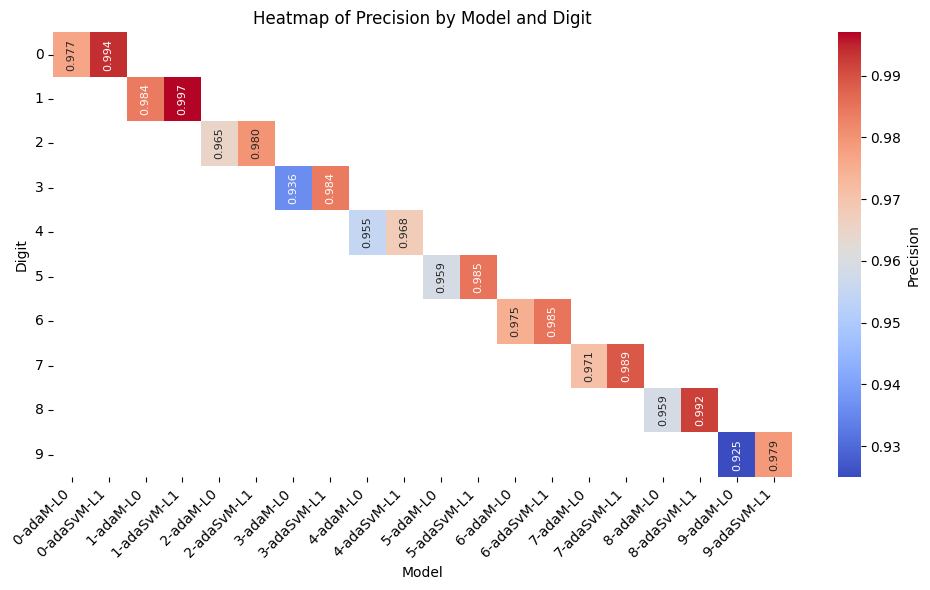

In [752]:
plot_single_metric_heatmap(adaM_adaSvM_results_df, 'precision', colorMap='coolwarm')

The performance difference in recall is even more pronounced than in precision. For the majority of digits, the soft AdaBoost ensemble noticeably outperforms the multiclass AdaBoost classifier. The only exception is digit 1, where both models exhibit similar recall values. This underscores the superior ability of one-vs-all models to learn effective decision boundaries compared to the multiclass classifier.

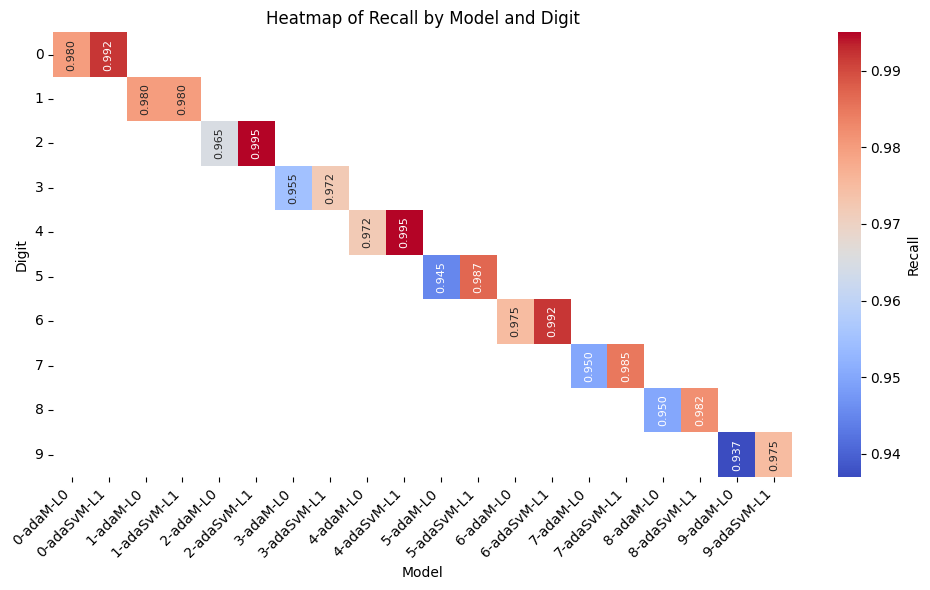

In [753]:
plot_single_metric_heatmap(adaM_adaSvM_results_df, 'recall', colorMap='coolwarm')

### Heatmap of Percentage Gains: Soft AdaBoost Ensemble vs. Multiclass AdaBoost

The heatmap above illustrates the percentage gains in performance metrics of the soft AdaBoost ensemble (adaSvM) over the direct multiclass AdaBoost classifier (adaM) for each digit (0–9). The metrics compared include **F1-score**, **precision**, **recall**, **accuracy**, and **ROC AUC**. Each cell represents the relative improvement of the ensemble model over the multiclass model, measured as a percentage, with darker shades indicating larger gains.

### Key Observations on Gains

1. **Overall Performance Boost**: The soft AdaBoost ensemble shows consistent gains across all digits and metrics, reaffirming its superior performance over the direct multiclass classifier.

2. **Biggest Gains**:
   - **Digit 9** exhibits the most significant improvements across multiple metrics, particularly in **precision (5.84%)**, **F1-score (4.94%)**, and **recall (4.06%)**. This highlights the ensemble’s ability to handle challenging digits more effectively.
   - **Digit 5** also demonstrates substantial gains, particularly in **accuracy (4.44%)** and **F1-score (3.57%)**, suggesting that the ensemble model resolves some of the confusion observed for this digit in the multiclass classifier.

3. **Moderate Gains**: For digits like **3** and **7**, the improvements are relatively modest but still noteworthy, with percentage increases concentrated in **recall (5.13% for digit 3)** and **accuracy (3.68% for digit 7)**.

4. **Consistent Gains in Recall**: Recall gains are visible across most digits, indicating the ensemble model’s enhanced ability to correctly identify positive cases for each digit.

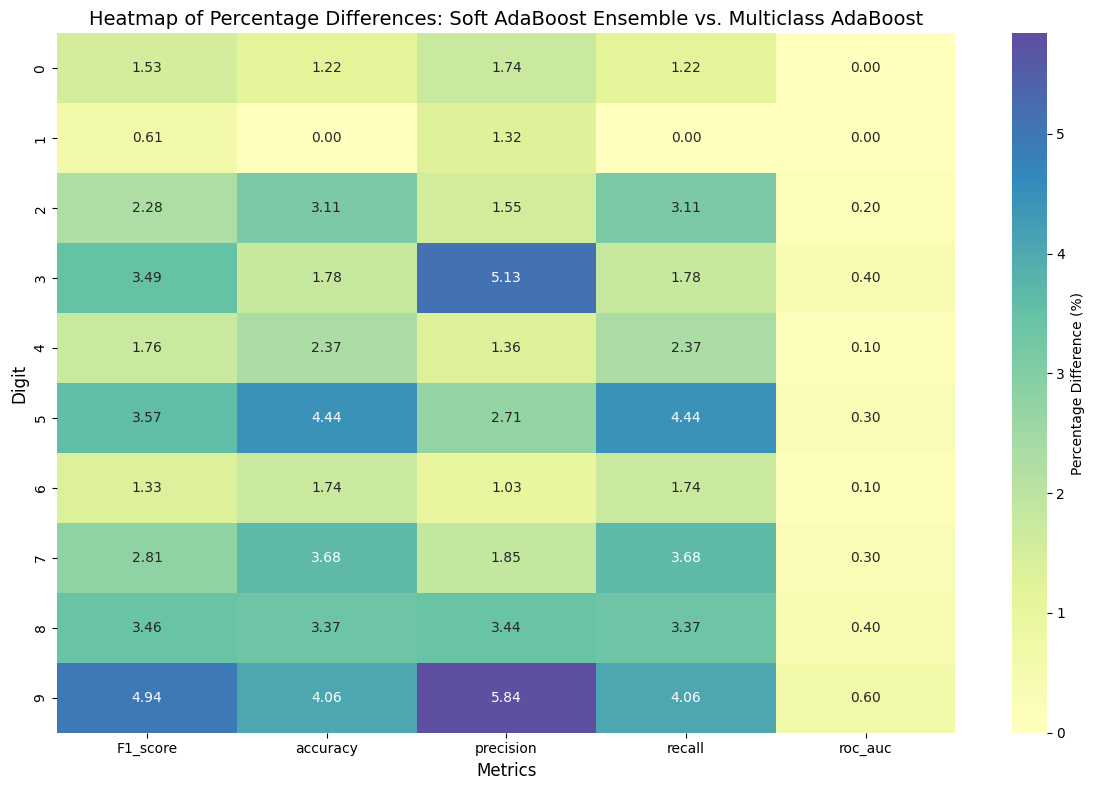

In [845]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compute_and_plot_percentage_diff(df1, df2, metrics, model1_name, model2_name):
    """
    Compute percentage differences between two dataframes and plot a heatmap.

    Parameters:
    - df1: DataFrame, metrics for the first model (e.g., ensemble model).
    - df2: DataFrame, metrics for the second model (e.g., multiclass model).
    - metrics: List of metric column names to compare (e.g., ['F1_score', 'precision', 'recall', 'accuracy', 'roc_auc']).
    - model1_name: str, name of the first model for labeling.
    - model2_name: str, name of the second model for labeling.

    Returns:
    - A heatmap of percentage differences for each metric per digit.
    """
    # Ensure both DataFrames are sorted by digit
    df1 = df1.sort_values(by="Digit").reset_index(drop=True)
    df2 = df2.sort_values(by="Digit").reset_index(drop=True)
    
    # Compute percentage differences for specified metrics
    percentage_diffs = []
    for metric in metrics:
        for digit in range(10):
            value1 = df1.loc[df1["Digit"] == digit, metric].values[0]
            value2 = df2.loc[df2["Digit"] == digit, metric].values[0]
            percentage_diff = ((value1 - value2) / value2) * 100
            percentage_diffs.append({
                "Digit": digit,
                "Metric": metric,
                "Percentage Difference (%)": percentage_diff
            })

    # Create a DataFrame for the percentage differences
    comparison_df = pd.DataFrame(percentage_diffs)
    
    # Plot the heatmap
    heatmap_data = comparison_df.pivot(index="Digit", columns="Metric", values="Percentage Difference (%)")
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data, annot=True, fmt=".2f", cmap="Spectral", center=0, 
        cbar_kws={"label": "Percentage Difference (%)"}
    )
    plt.title(f"Heatmap of Percentage Differences: {model1_name} vs. {model2_name}", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Digit", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Example usage:
metrics_to_compare = ["F1_score", "precision", "recall", "accuracy", "roc_auc"]
comparison_df = compute_and_plot_percentage_diff(adaSvM_results_df, adaM_results_df, metrics_to_compare, "Soft AdaBoost Ensemble", "Multiclass AdaBoost")

### 6.4. Why Ensemble Of One-vs-All AdaBoost Models Outperformed Multiclass AdaBoost

The superior performance of one-vs-all AdaBoost models for the corresponding digit stems from fundamental differences in how one-vs-all training and multiclass training address the classification task. These differences shape the decision boundaries, optimization focus, and overall effectiveness:

#### 1. Binary vs. Multiclass Optimization Objective
**One-vs-All Models:**  
Each one-vs-all model focuses exclusively on distinguishing one digit (positive class) from all others (negative class). This singular focus simplifies the decision boundary for each model, as it only needs to separate a single class from a combined "not-this-class" group. This binary optimization is often easier to optimize than a multiclass objective because the model only has to make a single binary decision.

**Multiclass Models:**  
Multiclass AdaBoost, on the other hand, must optimize for all classes simultaneously. This increases the complexity of the decision-making process, as the model must learn multiple decision boundaries in a shared feature space. These additional complexities can lead to suboptimal performance for specific classes.

#### 2. Data Imbalance in Multiclass Setup
**One-vs-All Models:**  
In the one-vs-all setting, the positive class is relatively small compared to the negative class, but the model explicitly trains to address this imbalance for each digit. Each model is incentivized to focus entirely on the positive class without competing priorities.  

**Multiclass Models:**  
In contrast, multiclass training minimizes the overall multiclass loss, which can underweight the contribution of smaller classes. This may lead to underfitting for specific digits, especially those with less representation or complex patterns.

#### 3. SAMME Algorithm Limitations in Multiclass
AdaBoost's SAMME algorithm extends AdaBoost to multiclass problems, but it has known limitations as the number of classes increases:  
- It is less sensitive to individual class errors, which may lead to suboptimal performance for specific classes.  
- The shared loss function in SAMME prioritizes overall optimization rather than addressing the nuances of individual class errors.  
In contrast, the binary SAMME formulation in one-vs-all models excels in creating precise decision boundaries for a single class.

#### 4. Shared Model Complexity in Multiclass
**Multiclass AdaBoost:**  
In the multiclass setup, all classes share the same weak learners (e.g., decision stumps or trees). These shared learners attempt to balance their decisions across all classes, which can dilute their effectiveness for any single class.  

**One-vs-All Models:**  
Each one-vs-all AdaBoost model uses its own set of weak learners, allowing them to specialize in identifying patterns unique to their specific digit.

#### 5. Overlapping Feature Space
In the multiclass setup, overlapping features between classes can confuse the model. For example, digits with similar shapes (e.g., 3 and 8) may present conflicting patterns.  
One-vs-all models reduce this issue by focusing exclusively on separating one class from the rest, ignoring intra-class overlaps in the ***not-this-class*** group.

#### 6. Hyperparameter Sensitivity
The same hyperparameters may not be optimal for both binary and multiclass setups. For example:
- Multiclass AdaBoost often requires higher values for `n_estimators` or different learning rates to manage the complexities of multiple decision boundaries.  
- One-vs-all models can often achieve better results with simpler configurations, as each model optimizes for a binary task.  
Hyperparameter tuning, such as grid search or Bayesian optimization, could improve multiclass performance, but this requires additional effort.

#### Key Takeaway
The one-vs-all AdaBoost models outperform the multiclass implementation by leveraging their binary focus and specialized training for individual classes. This advantage results in superior precision, recall, and overall performance for each digit, especially for challenging cases where the multiclass model struggles.

### 6.5. Benchamarking Soft Voting Ensemble vs XGB And LighGBM Classifiers

With the utter defeat of the multiclass AdaBoost, nerves are brteaking to see how the ensebmle does against its two mighty rivals. In this case, we shall visualize the accuracy as well, although our aim has been focusing on building classiferis that perform great in F1-score. Note that we will use `Spectral` for coloring the performances because it makes a sharper distinction even between small differences among the values, thus making it easier to notice which model is doing how comapred to its rivals.

In [756]:
xgb_lgbm_adaSvM_L1_results_df = pd.concat([lgbmM_results_df,xgbM_results_df,adaSvM_L1_results_df])

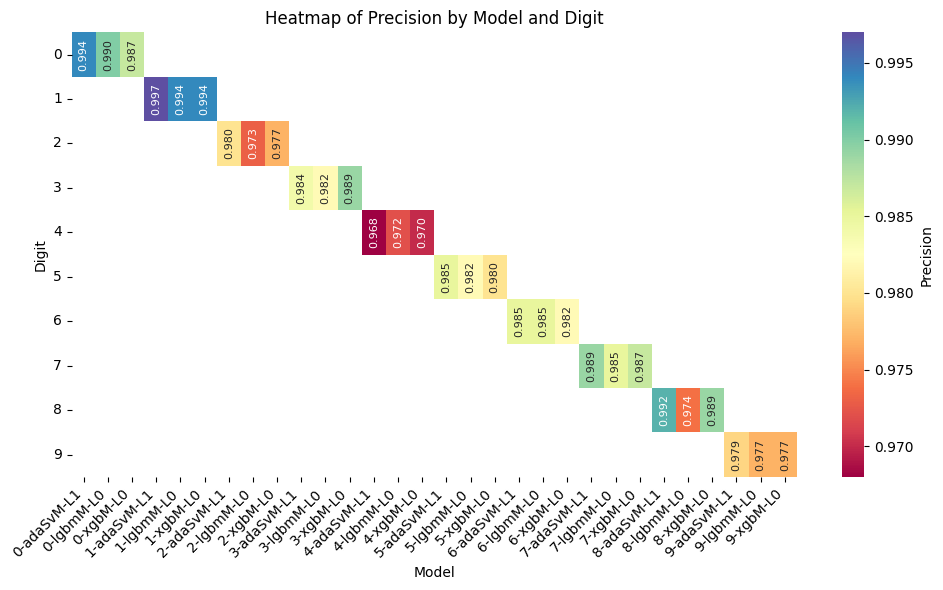

In [758]:
plot_single_metric_heatmap(xgb_lgbm_adaSvM_L1_results_df, 'precision', colorMap='Spectral')

##### **Observations on Precision**

The heatmap for precision reveals key differences in how XGBoost (xgbM), LightGBM (lgbmM), and the soft AdaBoost ensemble (adaSvM) handle digit classification:

1. **General Superiority of Soft AdaBoost Ensemble (adaSvM):** The soft voting AdaBoost ensemble leads in precision across the majority of digits. Its standout performance is especially evident for digits like 3, 4, and 9, where adaSvM achieves the largest gains. This demonstrates its ability to tackle more challenging digit classifications effectively.

2. **Competitiveness of XGBoost (xgbM):** XGBoost proves highly competitive, particularly for digits like 0, 1, and 8, where its precision is on par with or slightly better than adaSvM. However, for more difficult digits such as 3 and 9, XGBoost falls short, with adaSvM taking a clear lead.

3. **LightGBM’s Consistency (lgbmM):** LightGBM shows consistent precision across digits but rarely dominates any specific class. For digits such as 7 and 8, LightGBM performs closely to XGBoost, but for digits with larger precision gaps—like 3 and 9—it lags behind adaSvM.

4. **Digits with Noticeable Variance:** Digits 3 and 9 emerge as particularly challenging for both XGBoost and LightGBM, where adaSvM exhibits a significant edge in precision. Conversely, digits like 1 and 7 show minimal differences across the three models, indicating they are relatively easier to classify accurately.

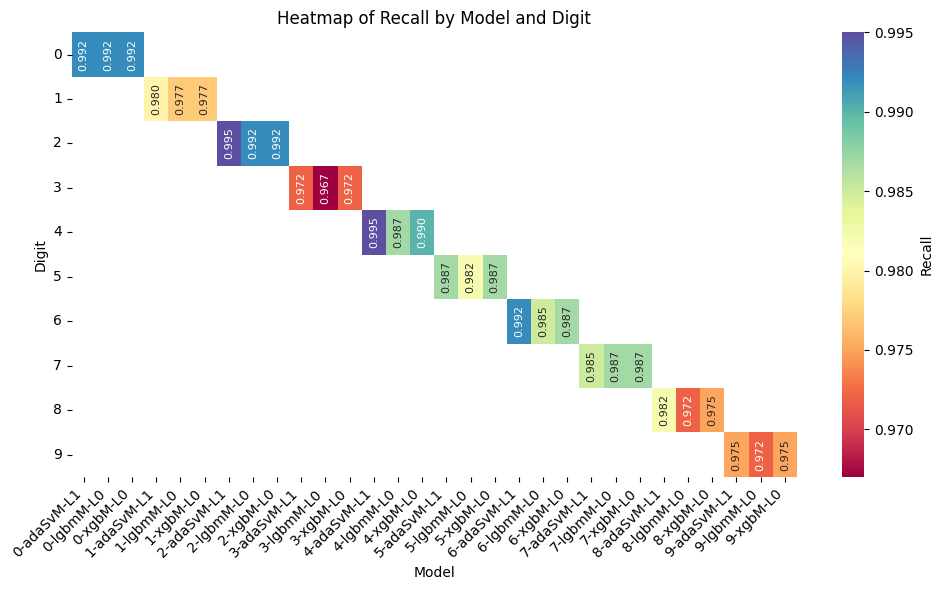

In [759]:
plot_single_metric_heatmap(xgb_lgbm_adaSvM_L1_results_df, 'recall', colorMap='Spectral')

##### **Observations on Recall**

The heatmap for recall offers additional insights into how XGBoost (xgbM), LightGBM (lgbmM), and the soft AdaBoost ensemble (adaSvM) perform across the digits:

1. **Dominance of Soft AdaBoost Ensemble (adaSvM):** The soft AdaBoost ensemble consistently takes the lead in recall across nearly all digits. Its superior performance is particularly evident for challenging digits like 3 and 9, where adaSvM significantly outpaces both XGBoost and LightGBM in recall values.

2. **XGBoost’s Strengths and Weaknesses (xgbM):** XGBoost continues to deliver strong recall for digits such as 0, 1, and 8, holding its ground against adaSvM in these cases. However, for tougher digits like 3 and 9, XGBoost falls short, with adaSvM demonstrating a clear advantage.

3. **LightGBM’s Consistency (lgbmM):** LightGBM exhibits consistent recall across the board but generally lags behind adaSvM. For digits like 7 and 8, LightGBM performs on par with XGBoost but is still outperformed by the soft AdaBoost ensemble.

4. **Key Gaps in Recall:** The most noticeable gaps in recall occur for digits 4 and 9, where adaSvM’s superior ability to recall challenging classes becomes apparent. Interestingly, digit 1 shows minimal differences across all models, suggesting it is relatively easier to classify for all methods.

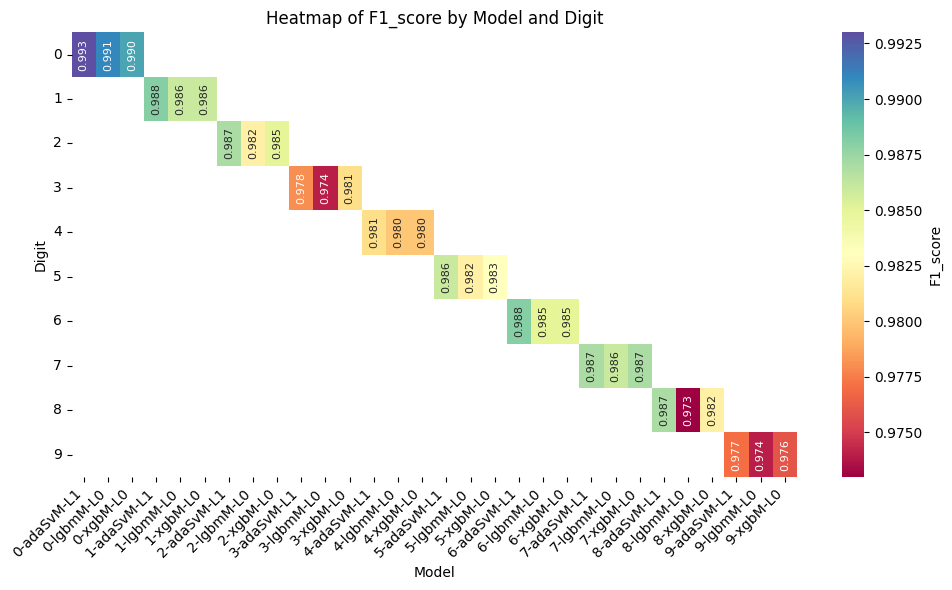

In [760]:
plot_single_metric_heatmap(xgb_lgbm_adaSvM_L1_results_df, 'F1_score', colorMap='Spectral')

##### **Observations on F1-score**

The F1-score heatmap reaffirms the soft AdaBoost ensemble's championship performance, consistently outshining XGBoost and LightGBM across almost all digits. The largest performance gaps between adaSvM and its rivals occur for digits 3, 4, and 9, where the ensemble clearly demonstrates its superior handling of complex class boundaries.

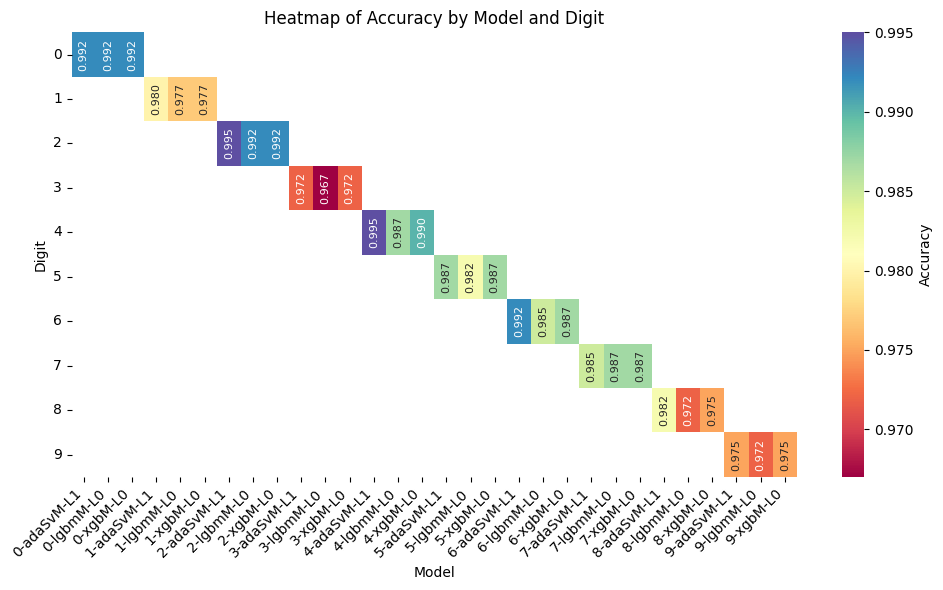

In [761]:
plot_single_metric_heatmap(xgb_lgbm_adaSvM_L1_results_df, 'accuracy', colorMap='Spectral')

##### **Observations on Accuracy**

1. **Soft AdaBoost Ensemble’s Stronghold (adaSvM):** The soft AdaBoost ensemble truly shines in this comparison, achieving the highest accuracy across most digits. Its ability to consistently classify instances correctly sets it apart. Pay special attention to digits like 3, 4, and 9, where the improvements in accuracy over XGBoost and LightGBM are particularly impressive.

2. **XGBoost’s Competitive Performance (xgbM):** XGBoost continues to hold its ground with high accuracy for digits such as 0, 1, and 8. While it sometimes trails slightly behind the soft AdaBoost ensemble, it remains a solid performer, showcasing its reliability even with more challenging digits.

3. **LightGBM’s Stability (lgbmM):** LightGBM proves itself as a stable and consistent model, particularly excelling for digits 2, 6, and 7, where its accuracy closely matches XGBoost. However, it does encounter challenges with digits like 3 and 4, where its performance visibly lags behind both XGBoost and the soft AdaBoost ensemble.

4. **Multiclass AdaBoost’s Underperformance (adaM):** The direct multiclass AdaBoost struggles to keep up with the other models. Its accuracy consistently falls behind, and the gap is most evident for digits like 3, 4, and 9. This performance difference underscores the limitations of the multiclass AdaBoost and highlights why the one-vs-all ensemble approach is so effective.

5. **Key Insights:** The soft AdaBoost ensemble emerges as the clear leader in terms of accuracy, outperforming XGBoost and LightGBM across the board. Digits 3 and 4, which prove challenging for the multiclass AdaBoost, are handled much better by the ensemble approach. This not only reinforces the ensemble’s effectiveness but also cements its position as the best-performing model in this analysis.

The heatmap vividly illustrates the superior performance of the one-vs-all AdaBoost ensemble. Its accuracy improvements, especially for the more difficult digits, highlight the power of this approach and its capacity to set a new benchmark in multiclass classification.

## 6.6. Error Analysis

### Error Analysis

We present the confusion heatmaps for the three models below. These visualizations provide valuable insights into the models' behavior, specifically how they differentiate between digits and where they falter. By analyzing these heatmaps, we can identify the digits that are frequently misclassified and uncover patterns of confusion. This, in turn, highlights the more challenging digits for the models to classify accurately. Such information is instrumental in guiding future efforts, whether through targeted data augmentation, feature engineering, or other optimization techniques, to enhance overall performance strategically.

### Common Misclassifications Across Models

- **Digit 9 Misclassified as Digit 7**: Across all three models (XGBoost, LightGBM, and the soft voting multiclass classifier), digit 9 is often misclassified as digit 7.
- This is likely due to structural similarities in the handwritten shapes of these digits, causing consistent confusion.

- **Digit 5 Misclassified as Digit 3**: A notable confusion across the models is between digits 5 and 3. The looping structures and curves in these digits can lead to their misinterpretation.

- **Digit 4 Misclassified as Digit 9**: Digit 4 occasionally gets confused with digit 9. This may stem from certain handwritten styles where digit 4 resembles a partially formed 9.

- **Digit 8 Confusions** Digit 8 appears as a source of confusion for various digits. Its complex looping structure makes it susceptible to misclassification, although the exact pairs of confusion vary slightly across the models.

In [815]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_log_confusion_heatmap(model, X_test, y_true, class_labels=list(range(10)), is_lgbm=False, colorMap="Spectral"):
    """
    Plot a confusion matrix with logarithmic scaling as a heatmap.

    Parameters:
    - model: Trained classifier with `predict` or `predict_proba` method.
    - X_test: Test feature data.
    - y_true: True class labels (array-like).
    - class_labels: List of class labels (default is [0-9]).
    - is_lgbm: Bool, set to True if the model is a LightGBM classifier.
    """
    # Predict class labels
    if is_lgbm:
        y_pred_probs = model.predict(X_test)  # LightGBM outputs probabilities
        y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class predictions
    else:
        y_pred = model.predict(X_test)  # For other models like XGBoost, directly get predictions

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Apply logarithmic scaling to the confusion matrix
    cm_log = np.log1p(cm)  # Use log1p to handle zero values safely

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_log, annot=True, fmt='.2f', cmap=colorMap, 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{model.__class__.__name__} Confusion Heatmap (Logarithmic Scale)", fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.show()

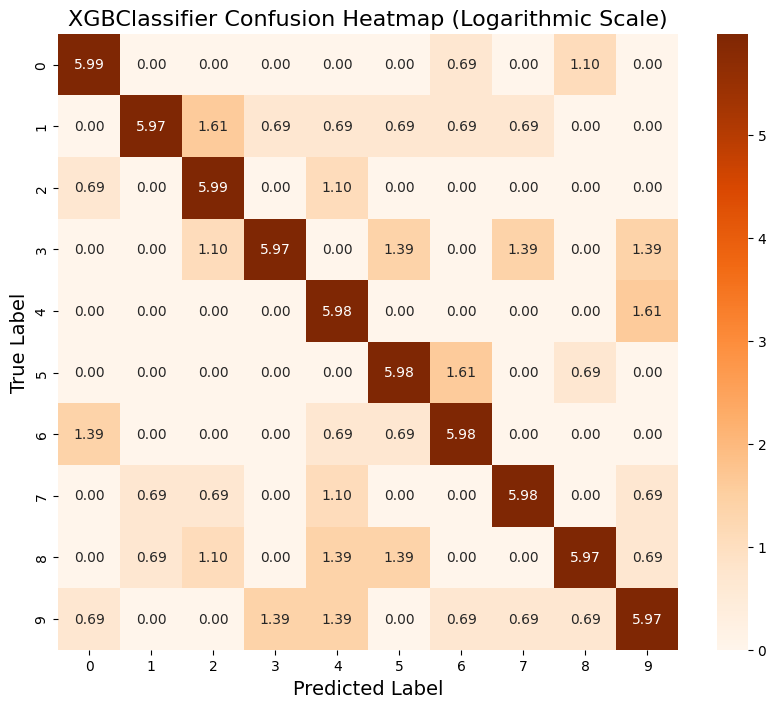

In [838]:
plot_log_confusion_heatmap(xgb_multiclass, X_3, y_3, colorMap='Oranges')

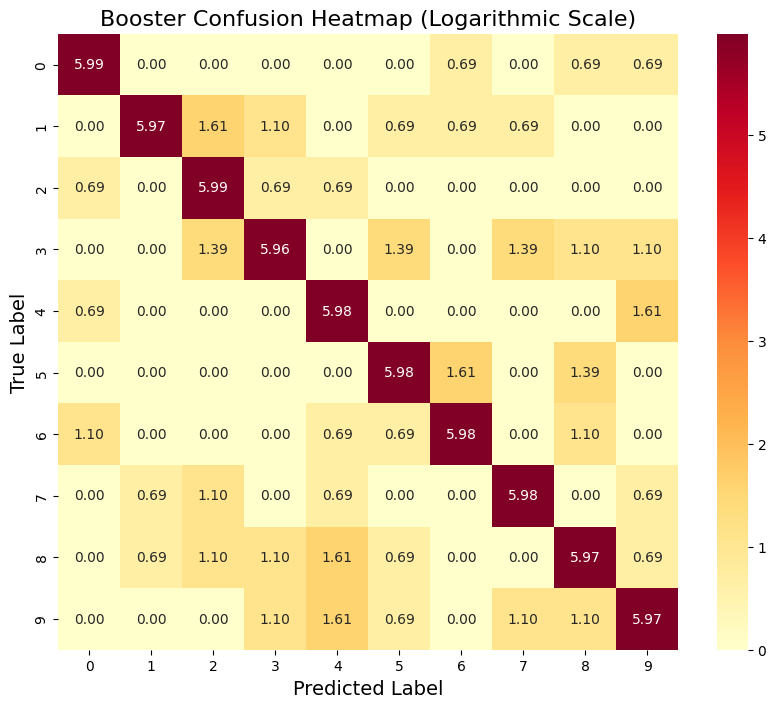

In [835]:
plot_log_confusion_heatmap(lgbm_model, X_3, y_3, is_lgbm=True, colorMap='YlOrRd')

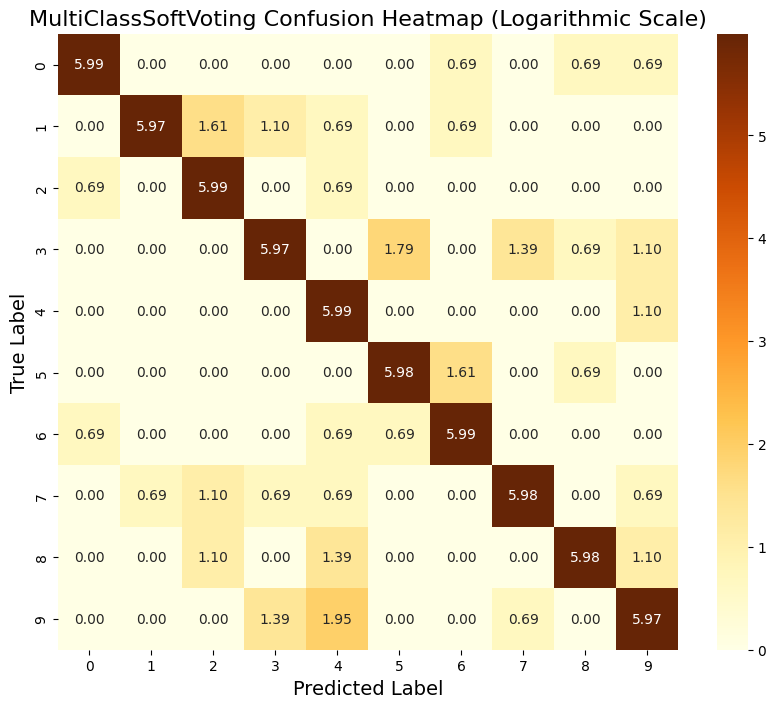

In [834]:
plot_log_confusion_heatmap(adaSoftVoting_multiclass, X_3, y_3, colorMap='YlOrBr')

### Insights on Model Confusions and Next Steps

One of the interesting aspects of analyzing confusion heatmaps across different models is identifying whether a soft or hard voting ensemble could yield better performance. Typically, such an approach can capitalize on models making different types of errors, leading to improved overall classification. However, in this case, while the confusion patterns are minimal, the differences between the models in terms of misclassification are negligible in both quality and quantity. As a result, ensembling the models would not offer significant benefits.

This realization opens the door for a broader reflection: there are inherent limitations to improving performance through algorithmic tuning, ensembling, or hyperparameter optimization alone. Some challenging cases—like digits 3, 7, 8, and 9 in this analysis—persist across all models, highlighting their fundamental difficulty regardless of the approach.

#### Exploring Hyperparameter Tuning
While one could stubbornly persist in algorithmic optimization, such as hyperparameter tuning, particularly for models like XGBoost and LightGBM, which are computationally cheaper to train, the likelihood of significant returns is slim. Given the already high performance achieved, any improvements from this effort are expected to be marginal. Moreover, hyperparameter tuning can demand substantial time and resources, especially when results largely depend on luck in stumbling upon better configurations. For those determined to continue exploring algorithmic tricks, this could still be a valid, albeit narrow, path forward.

#### A Data-Centric Perspective
Instead of focusing solely on algorithmic enhancements, a data-centric approach may prove more fruitful. This involves strategies such as:
- **Data Augmentation**: Generating synthetic variations of challenging digits to increase diversity in the training set and improve model generalization.
- **Careful Feature Engineering**: Introducing new features or transforming existing ones to better capture the subtle distinctions between confusing classes. However, caution is warranted here; over-engineering features or introducing careless transformations could backfire, exacerbating misclassification.

#### Concluding Remarks
At this stage, the stubborn misclassifications suggest diminishing returns from further algorithmic refinements. Exploring data-centric solutions, including augmentation and targeted feature engineering, may offer a more promising path for addressing these persistent errors. This shift in perspective highlights the balance between algorithmic and data-driven approaches in achieving optimal performance.

### 6.7. Quantifying Model Generalizability And Uncertainty

The plot reveals that the Soft AdaBoost Ensemble consistently maintains higher precision, recall, and F1-score across train, validation, and test datasets compared to XGBoost and LightGBM. While all models show a noticeable drop from train to validation, the ensemble stabilizes better on test data. XGBoost demonstrates strong generalization closely trailing the ensemble. LightGBM suffers the largest declines, especially in precision and F1-score. Compared to the other two, it may struggle more in maintaining performance on unseen data.

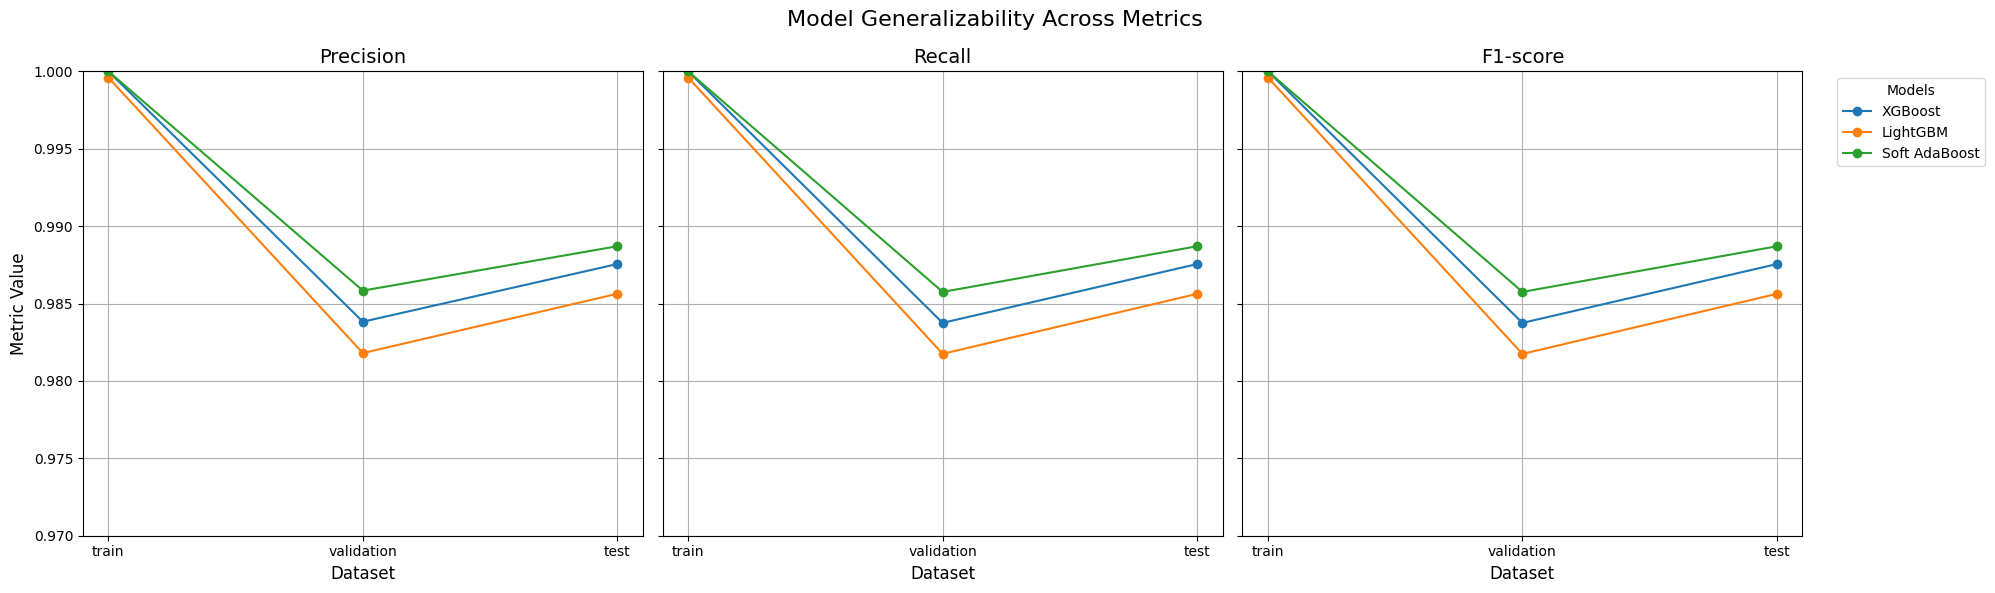

In [882]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Correct metrics names based on the classification report output
metrics = ["precision", "recall", "f1-score"]

# Wrapper for evaluating models
def evaluate_model_wrapper(model, X, y, model_type="multiclass"):
    """
    Evaluate a model using the provided evaluation functions.

    Parameters:
    - model: Trained classifier.
    - X: Features.
    - y: True labels.
    - model_type: Type of the model ("multiclass", "lgbm", or "soft_voting").

    Returns:
    - dict: Evaluation results from the respective function.
    """
    if model_type == "lgbm":
        y_pred_probs = model.predict(X)
        y_pred = np.argmax(y_pred_probs, axis=1)
        return evaluate_multiclass_model(y, y_pred, y_pred_probs)
    elif model_type == "xgb":
        y_pred_probs = model.predict_proba(X)
        y_pred = np.argmax(y_pred_probs, axis=1)
        return evaluate_multiclass_model(y, y_pred, y_pred_probs)
    elif model_type == "softVotingMulticlass":
        y_pred_probs = model.predict_proba(X)
        y_pred = np.argmax(y_pred_probs, axis=1)
        return evaluate_soft_voting_model(y, y_pred, y_pred_probs)
    else:
        raise ValueError("Invalid model_type. Use 'multiclass', 'lgbm', or 'soft_voting'.")

random_train = create_balanced_subset_mask(y_0, n_per_digit=4000, random_state=42)

# Preparing datasets
datasets = {
    "train": (X_0[random_train], y_0[random_train]),
    "validation": (X_3, y_3),
    "test": (test_digits_flattened[:, feature_sets["SHAP"]], test_digits_labels)  # Apply SHAP for test
}

# Evaluating models on all datasets
models = {
    "XGBoost": (xgb_multiclass, "xgb"),
    "LightGBM": (lgbm_model, "lgbm"),
    "Soft AdaBoost": (adaSoftVoting_multiclass, "softVotingMulticlass")
}

model_results = {}
for model_name, (model, model_type) in models.items():
    model_results[model_name] = {
        dataset_name: evaluate_model_wrapper(model, X, y, model_type=model_type)
        for dataset_name, (X, y) in datasets.items()
    }

# Visualization of all models in one plot
def plot_combined_generalizability(results_dict):
    """
    Plot all models' generalizability metrics on a single plot.

    Parameters:
    - results_dict: Dictionary of results for all models across datasets.
    """
    datasets = ["train", "validation", "test"]
    colors = ["b", "g", "r", "c", "m"]

    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6), sharey=True)

    for i, metric in enumerate(metrics):
        ax = axes[i]
        for model_name, dataset_results in results_dict.items():
            metric_values = []
            for dataset_name in datasets:
                classification_report = dataset_results[dataset_name]["Classification Report"]
                if metric == "accuracy":
                    metric_values.append(dataset_results[dataset_name]["Per-Class Accuracy"].get("overall", np.nan))
                else:
                    metric_values.append(classification_report.loc["weighted avg", metric])
            ax.plot(datasets, metric_values, marker='o', label=model_name)
        ax.set_title(metric.capitalize(), fontsize=14)
        ax.set_xlabel("Dataset", fontsize=12)
        if i == 0:
            ax.set_ylabel("Metric Value", fontsize=12)
        ax.set_ylim(0.97, 1.0)
        ax.grid(True)
        if i == len(metrics) - 1:
            ax.legend(title="Models", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

    fig.suptitle("Model Generalizability Across Metrics", fontsize=16)
    fig.tight_layout()
    plt.show()

plot_combined_generalizability(model_results)

### 6.7.1. Measuring Generalizability By Quantifying Model Uncertainty

While the typical evaluation of generalizability using metrics like precision, recall, and accuracy across train, validation, and test datasets provides critical insights, it focuses primarily on the **aggregate performance** of a model. These metrics, however, do not directly account for the **uncertainty** in the model's predictions, which is particularly important in edge cases or ambiguous samples where traditional metrics fall short. Predictive entropy provides a complementary perspective by quantifying the model’s confidence and reliability.

### 6.7.1.1. Predictive Entropy

Predictive entropy quantifies the uncertainty of a model’s predictions by measuring the spread of predicted probabilities across all possible classes for a given input. It is defined as:

>
> $H(y) = -\sum_{i=1}^{C} p(y_i) \log(p(y_i))$
>

Where:
- $H(y)$ is the predictive entropy,
- $C$ is the total number of classes,
- $p(y_i)$ is the predicted probability for class $i$.

#### What Does Predictive Entropy Measure?

1. **Low Predictive Entropy**:
   - Indicates **high confidence** in the model’s predictions.
   - The predicted probabilities are **concentrated** on a single class (e.g., $p(y_i) \approx 1$ for one class and $p(y_i) \approx 0$ for others).
   - In entropy plots, low entropy appears as a cluster of samples with small values, reflecting certain predictions.

2. **High Predictive Entropy**:
   - Reflects **high uncertainty** in the model’s predictions.
   - The predicted probabilities are **spread** across multiple classes (e.g., $p(y_i)$ is nearly equal for several classes, such as $p(y_1) \approx 0.3, p(y_2) \approx 0.4, p(y_3) \approx 0.3$).
   - In entropy plots, high entropy corresponds to a wider distribution, indicating the model’s uncertainty.

3. **Behavior Across Data**:
   - Predictive entropy reveals how the model behaves on **train**, **validation**, and **test** datasets, offering insights into the confidence and uncertainty associated with its predictions.

### Relation to Generalizability Testing

Predictive entropy provides an indirect yet powerful lens to evaluate a model's **generalizability** by analyzing its uncertainty patterns across datasets:

- **Consistent entropy distributions** across train, validation, and test sets suggest that the model maintains similar confidence levels on unseen data, which is a hallmark of good generalizability.
- **Higher entropy on validation or test sets** compared to the training set indicates reduced confidence on unseen data, potentially signaling overfitting.
- **Per-class entropy analysis** can pinpoint specific classes where the model struggles, which can inform targeted improvements (e.g., data augmentation or better class-specific features).

#### Key Benefits for Generalizability

- **Detects Overconfidence**: A poorly generalized model may exhibit artificially low entropy on the training set but significantly higher entropy on validation or test sets.
- **Highlights Ambiguities**: Samples with high entropy often correspond to ambiguous or noisy data points, helping identify problematic instances.
- **Facilitates Model Comparisons**: Entropy distributions enable an additional dimension for comparing model reliability and robustness across datasets.
- **Supports Calibration Workflows**: Predictive entropy provides a quantitative basis for evaluating calibration workflows, such as those explored in Chapter 3. By understanding where models are overconfident or underconfident, predictive entropy can guide adjustments to align predicted probabilities more closely with observed frequencies.


In [898]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute predictive entropy for Bayesian Uncertainty Analysis
def compute_predictive_entropy(pred_probs):
    """
    Compute predictive entropy for a set of predicted probabilities.

    Parameters:
    - pred_probs: ndarray, predicted probabilities (n_samples, n_classes).

    Returns:
    - entropy: ndarray, predictive entropy values for each sample.
    """
    return -np.sum(pred_probs * np.log(pred_probs + 1e-10), axis=1)

# Wrapper to evaluate predictive entropy for all models
def evaluate_predictive_entropy(models, datasets):
    """
    Evaluate predictive entropy for all models and datasets.

    Parameters:
    - models: dict, keys are model names and values are tuples (model, type).
    - datasets: dict, keys are dataset names and values are (X, y).

    Returns:
    - entropy_metrics: dict, containing entropy distributions for all models and datasets.
    """
    entropy_metrics = {model_name: {} for model_name in models.keys()}

    # Compute entropy for each model and dataset
    for model_name, (model, model_type) in models.items():
        for dataset_name, (X, y) in datasets.items():
            if model_type == "lgbm":
                pred_probs = model.predict(X)
            else:
                pred_probs = model.predict_proba(X)
            
            # Predictive Entropy
            entropy = compute_predictive_entropy(pred_probs)
            entropy_metrics[model_name][dataset_name] = entropy

    return entropy_metrics

# Visualize Predictive Entropy for each model and dataset
def plot_predictive_entropy(entropy_metrics):
    """
    Plot predictive entropy distributions for all models and datasets.

    Parameters:
    - entropy_metrics: dict, containing entropy distributions for each model and dataset.
    """
    for model_name, dataset_metrics in entropy_metrics.items():
        plt.figure(figsize=(10, 6))
        for dataset_name, entropy in dataset_metrics.items():
            plt.hist(entropy, bins=30, alpha=0.5, label=f"{dataset_name.capitalize()}")
        plt.title(f"Predictive Entropy for {model_name}", fontsize=16)
        plt.xlabel("Entropy", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Define your models and datasets
models = {
    "XGBoost": (xgb_multiclass, "xgb"),
    "LightGBM": (lgbm_model, "lgbm"),
    "Soft AdaBoost": (adaSoftVoting_multiclass, "softVotingMulticlass"),
}

datasets = {
    "Train": (X_0, y_0),
    "Validation": (X_3, y_3),
    "Test": (test_digits_flattened[:, feature_sets["SHAP"]], test_digits_labels),
}

In [899]:
# Compute predictive entropy
entropy_metrics = evaluate_predictive_entropy(models, datasets)

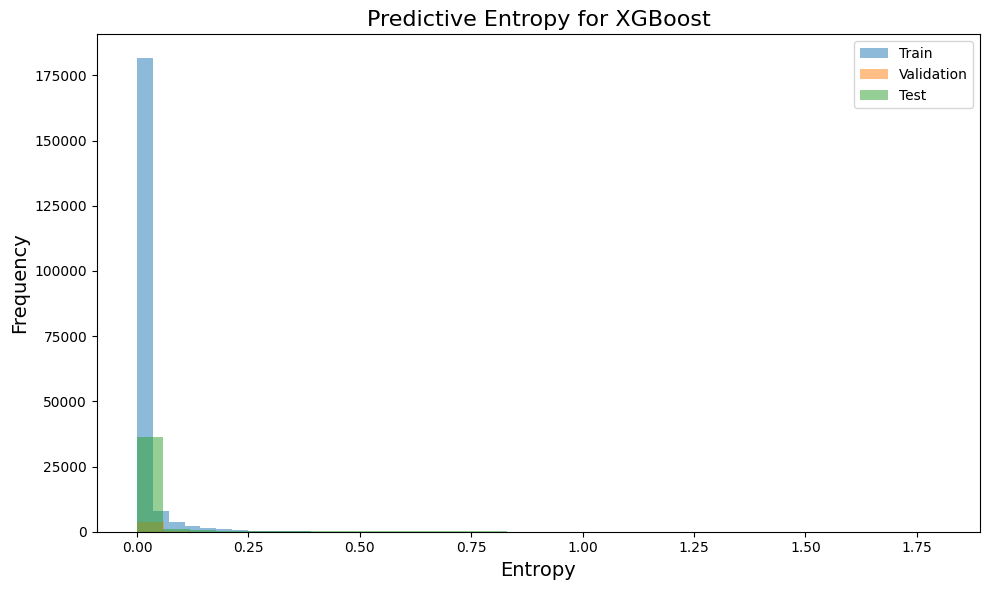

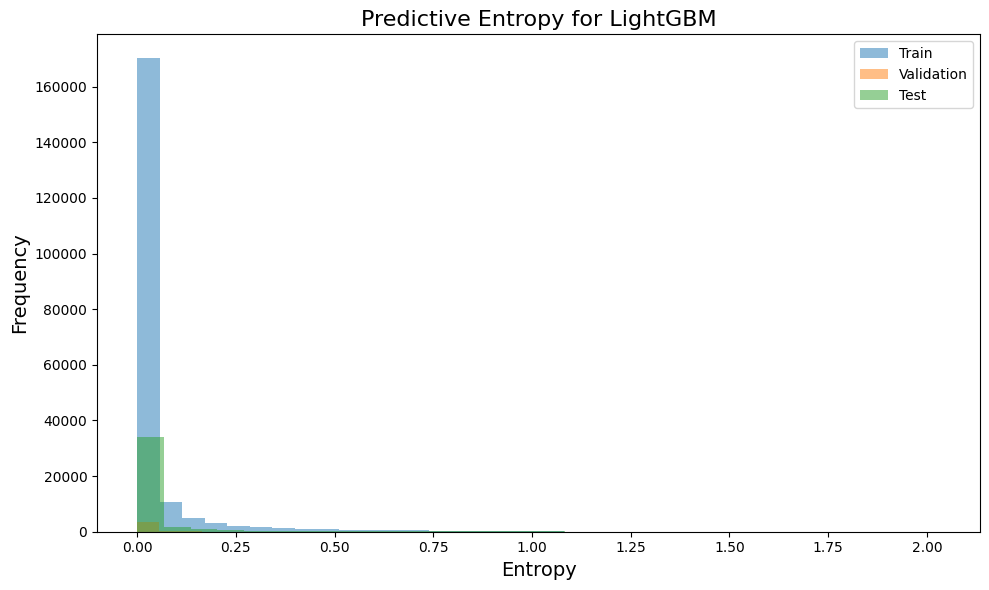

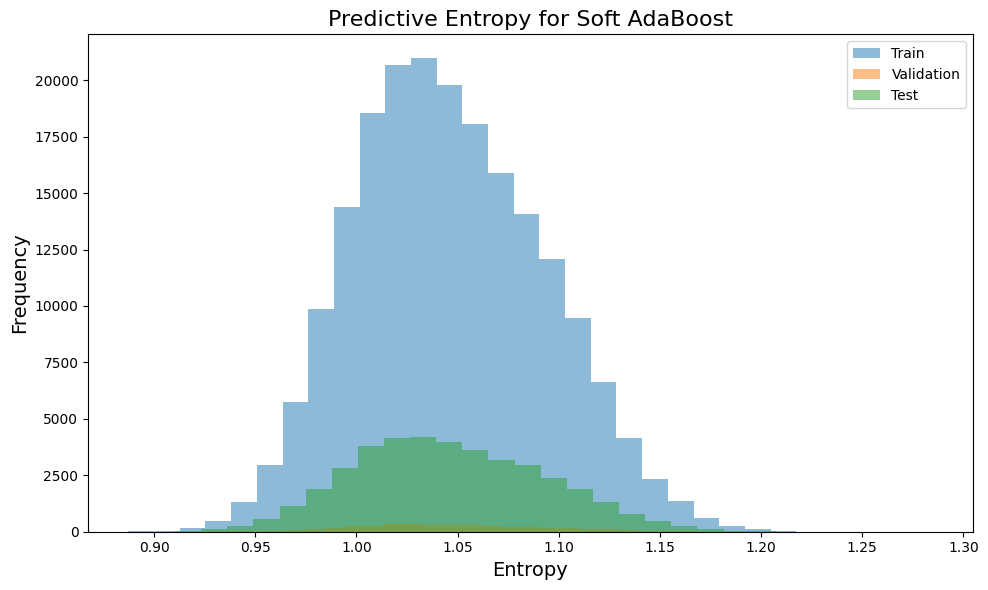

In [900]:
# Plot predictive entropy
plot_predictive_entropy(entropy_metrics)

### Interpretation of Predictive Entropy Results

1. **LightGBM:**
   - The predictive entropy distribution is highly concentrated near zero across all datasets (train, validation, and test).
   - This reflects very high confidence in predictions, with probabilities heavily skewed toward a single class.
   - The consistency of entropy distributions across datasets suggests strong generalizability but might also indicate overconfidence in predictions, as seen in the lack of spread in the entropy values.

2. **Soft AdaBoost:**
   - The entropy distribution is significantly wider compared to LightGBM, with values centered around 1.0.
   - This indicates a more balanced confidence level, with predictions not being overly dominated by one class.
   - The near-perfect overlap of entropy distributions for train, validation, and test datasets signals excellent generalizability and robustness.

3. **XGBoost:**
   - Similar to LightGBM, XGBoost shows extremely low entropy values concentrated near zero.
   - The sharp decay in the frequency distribution confirms a high level of confidence in predictions, though the consistency across datasets supports its generalizability.
   - The narrow range of entropy values indicates minimal ambiguity in predictions, mirroring the model's deterministic nature.

### Key Observations:
- **Generalizability:** All three models show consistent entropy distributions across train, validation, and test datasets, indicating no major degradation in confidence on unseen data.
- **Confidence Levels:** Soft AdaBoost exhibits higher entropy, which aligns with a more cautious and probabilistic approach. In contrast, XGBoost and LightGBM show overconfident behavior with tightly concentrated low-entropy predictions.
- **Model Comparison:** While LightGBM and XGBoost demonstrate similar behavior, Soft AdaBoost stands out for its broader entropy distribution, which may make it better suited for handling ambiguous or noisy data.

### 6.7.1.2. Distinguishing Overconfidence from Uncertainty in Generalizability

Entropy does not differentiate between genuine uncertainty and **overconfidence**, where a model might exhibit artificially low entropy despite poor generalizability. To address this, we compute Brier scores, which directly evaluate the calibration of predicted probabilities. While entropy measures the spread of predicted probabilities, Brier scores assess how well these probabilities align with actual outcomes. By analyzing Brier scores across all models and digits, we complement the entropy analysis, providing a clearer distinction between genuine uncertainty and overconfidence. This dual approach refines our understanding of model generalizability, capturing both the spread of predictions and their reliability.

In [904]:
import pandas as pd
from sklearn.metrics import brier_score_loss

def compute_brier_scores_all_digits(models, datasets):
    """
    Compute Brier scores for all models and digits (one-vs-rest) across datasets.

    Parameters:
    - models: dict, keys are model names and values are (model, model_type).
    - datasets: dict, keys are dataset names and values are (X, y).

    Returns:
    - brier_scores_df: DataFrame, containing Brier scores for each model, digit, and dataset.
    """
    results = []

    # Loop through all digits
    num_classes = len(np.unique(next(iter(datasets.values()))[1]))
    for target_digit in range(num_classes):
        for model_name, (model, model_type) in models.items():
            for dataset_name, (X, y) in datasets.items():
                # Get predicted probabilities
                if model_type == "lgbm":
                    pred_probs = model.predict(X)
                else:
                    pred_probs = model.predict_proba(X)

                # Binarize the labels for the target digit (one-vs-rest)
                y_binary = (y == target_digit).astype(int)

                # Extract the predicted probabilities for the target digit
                target_probs = pred_probs[:, target_digit]

                # Compute Brier score
                brier_score = brier_score_loss(y_binary, target_probs)

                # Append the result to the list
                results.append({
                    "Model": model_name,
                    "Digit": target_digit,
                    "Dataset": dataset_name,
                    "Brier Score": brier_score
                })

    # Convert the results to a dataframe
    brier_scores_df = pd.DataFrame(results)
    return brier_scores_df

# Example usage
# Compute Brier scores for all digits
brier_scores_df = compute_brier_scores_all_digits(models, datasets)

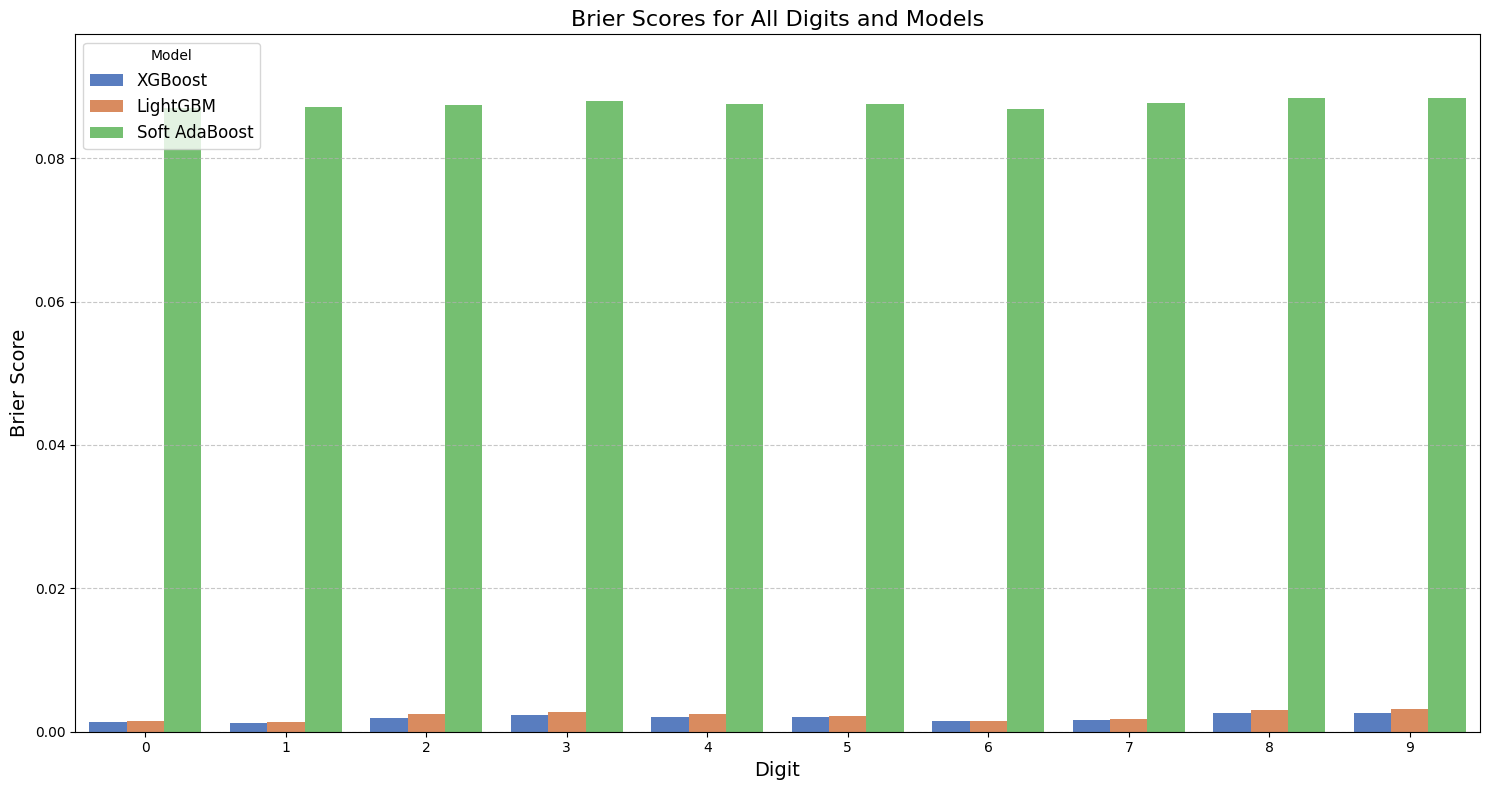

In [908]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_brier_scores_single(brier_scores_df):
    """
    Plots all Brier scores for every digit and model in a single plot.

    Parameters:
    - brier_scores_df: DataFrame containing Brier scores with columns 'Digit', 'Model', and 'Brier Score'.
    """
    plt.figure(figsize=(15, 8))

    # Create the plot
    sns.barplot(
        data=brier_scores_df,
        x="Digit",
        y="Brier Score",
        hue="Model",
        dodge=True,
        palette="muted"
    )

    # Add titles and labels
    plt.title("Brier Scores for All Digits and Models", fontsize=16)
    plt.xlabel("Digit", fontsize=14)
    plt.ylabel("Brier Score", fontsize=14)
    plt.ylim(0, brier_scores_df["Brier Score"].max() * 1.1)  # Fine-grained scale
    plt.legend(title="Model", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_all_brier_scores_single(brier_scores_df)

### Brier Scores Analysis and Insights

The Brier scores across all digits reveal clear trends in the performance and generalizability of the three models:

1. **Soft AdaBoost** consistently shows significantly higher Brier scores compared to XGBoost and LightGBM. This indicates poorer calibration of its predicted probabilities, suggesting that the model is overconfident in its predictions for all digits. This overconfidence aligns with what we observed in Chapter 3, where Soft AdaBoost exhibited overly optimistic probabilities in the 8-vs-all comparison, despite comparable or slightly better classification performance metrics (e.g., precision, recall).

2. **XGBoost** achieves the lowest Brier scores across all digits, demonstrating excellent calibration and reliability in its predicted probabilities. This model's low entropy and well-calibrated scores reinforce its strong generalizability, as seen in the earlier predictive entropy analysis.

3. **LightGBM** generally performs in the middle, with Brier scores higher than XGBoost but significantly lower than Soft AdaBoost. While its calibration is not as strong as XGBoost, it shows reasonable confidence levels and generalizability, consistent with its predictive entropy behavior.

4. **Tying Results to Generalizability**:
   - **Predictive Entropy Comparison**: The entropy results for Soft AdaBoost showed a more dispersed distribution, suggesting high confidence but also some uncertainty in predictions. The high Brier scores confirm that this confidence is not always well-calibrated, indicating a tendency toward overconfidence rather than genuine certainty.
   - **Generalizability**: While Soft AdaBoost performed well in traditional metrics like precision and recall across datasets, its Brier scores suggest overconfidence rather than superior generalizability. In contrast, XGBoost, with its low entropy and Brier scores, provides a more balanced view of confidence and uncertainty, reflecting better generalizability.

This analysis highlights the importance of combining multiple evaluation approaches—such as predictive entropy, calibration curves, and Brier scores—to fully understand model behavior and generalizability.

In [1]:
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import classification_report
import numpy as np

# Assuming `layer_0_models` is a dictionary of trained one-vs-all models
class MultiClassStackingWithGradientBoost:
    def __init__(self, layer_0_models):
        """
        Initialize the multiclass stacking classifier.

        Parameters:
        - layer_0_models: dict, one-vs-all models (keys are digit names, values are trained classifiers).
        """
        self.layer_0_models = layer_0_models
        self.stacking_classifier = None

    def fit(self, X, y):
        """
        Train the stacking classifier using predictions from base models.

        Parameters:
        - X: ndarray, training features.
        - y: ndarray, multiclass training labels.
        """
        # Use predictions from base models as meta-features
        meta_features = np.column_stack([
            model.predict_proba(X)[:, 1] for model in self.layer_0_models.values()
        ])
        
        # Gradient Boosting as the meta-model
        meta_model = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )

        # Stacking Classifier
        self.stacking_classifier = StackingClassifier(
            estimators=[(f"digit_{digit}", model) for digit, model in self.layer_0_models.items()],
            final_estimator=meta_model,
            passthrough=False
        )
        
        self.stacking_classifier.fit(X, y)

    def predict(self, X):
        """
        Predict class labels using the stacking classifier.

        Parameters:
        - X: ndarray, test features.

        Returns:
        - ndarray, predicted class labels.
        """
        return self.stacking_classifier.predict(X)

    def predict_proba(self, X):
        """
        Predict class probabilities using the stacking classifier.

        Parameters:
        - X: ndarray, test features.

        Returns:
        - ndarray, predicted probabilities.
        """
        return self.stacking_classifier.predict_proba(X)